# **ABC Campaing Analysis**

### **Context**
ABC Supermarket is planning for the year-end sale - they want to launch a new offer i.e. gold membership for only $499 that is of $999 on normal days(that gives 20% discount on all purchases) only for existing customers, for that they need to do a campaign through phone calls - the best way to reduce the cost of the campaign is to make a predictive model to classify customers who might purchase the offer, using the data they gathered during last year's campaign.

We will build a model for classifying whether customers will reply with a positive response or not.

---

### **Problem**
The data-set aims to answer the following key questions:
- What are the different factors which affect the target variable?
  - see **Section 3 Exploratory Data Analysis** for the visualization of each feature with the target variable
  - see **Section 4.4 Feature Selection** for the statistical analysis between the features and the target variable
- How can we improve model performance using hyperparameter tuning and prevent data leakage using pipelines while building a model to predict the response of a customer?
  - see **Section 5.3 Baseline Model** for the training of the baseline model
  - see **Section 5.5 Model Selection** for the hyperparameter tuning
- What business recommendations can we give based on the analysis and how do you recommend them to use the model? 
  - see **Section 6 Conclusion and Recommendation**
- Based on the model results, how can we measure the value the model brings? 
  - see **Section 5 Modelling** for the justification on the performance metrics used
  - see **Section 6 Conclusion and Recommendation** for the interpretation of results

---

### **Data Dictionary**
The data contains characteristics of the people with the following features:
- Response (target) - 1 if customer accepted the offer in the last campaign, 0
otherwise
- Complain - 1 if a customer complained in the last 2 years
- DtCustomer - date of customer’s enrolment with the company
- Education - customer’s level of education
- Marital - customer’s marital status
- Kidhome - number of small children in customer’s household
- Teenhome - number of teenagers in customer’s household
- Income - customer’s yearly household income
- MntFishProducts - the amount spent on fish products in the last 2 years
- MntMeatProducts - the amount spent on meat products in the last 2 years
- MntFruits - the amount spent on fruits products in the last 2 years
- MntSweetProducts - amount spent on sweet products in the last 2 years
- MntWines - the amount spent on wine products in the last 2 years
- MntGoldProds - the amount spent on gold products in the last 2 years
- NumDealsPurchases - number of purchases made with discount
- NumCatalogPurchases - number of purchases made using catalog
- NumStorePurchases - number of purchases made directly in stores
- NumWebPurchases - number of purchases made through the company’s web site
- NumWebVisitsMonth - number of visits to company’s web site in the last month
- Recency - number of days since the last purchase
- ID - unique customer-id
- Year_Birth - customer's year of birth


# 1. Import Libraries and Load the Dataset

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn
from tqdm import tqdm
import math
import warnings

# Libaries for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Libraries for modelling
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Libraries for evaluation
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)

# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
df = pd.read_excel('data/marketing_data.xlsx', sheet_name='marketing_data')

# Display a set of random rows from the dataset
df.sample(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
1524,5837,1967,Graduation,Married,51479.00,1,1,12/28/12,67,247,8,160,6,8,65,7,6,3,6,7,0,0
2151,2931,1978,Graduation,Divorced,71847.00,0,0,9/21/12,95,737,21,106,55,63,210,0,6,7,9,3,0,0
97,6379,1949,Master,Widow,47570.00,1,1,5/29/13,3,67,1,20,0,2,31,3,2,2,2,7,1,0
1021,10888,1961,Graduation,Single,45938.00,0,0,2013-03-11 00:00:00,46,273,11,178,62,83,29,2,8,4,6,6,0,0
1061,524,1966,Basic,Together,22634.00,0,0,1/16/13,47,2,23,11,8,6,46,1,2,1,2,8,0,0
1261,4749,1968,Graduation,Together,58554.00,1,1,9/26/12,55,368,24,68,38,0,88,6,8,2,6,7,0,0
1274,1328,1982,2n Cycle,Married,57937.00,0,1,2/16/14,56,261,42,144,55,48,133,3,4,4,9,3,0,0
723,9478,1985,Graduation,Single,66503.00,1,0,8/14/12,30,91,64,128,65,3,50,2,4,3,6,3,0,0
509,4088,1962,PhD,Together,31497.00,0,1,2012-06-12 00:00:00,22,108,1,28,13,1,4,2,3,1,4,8,0,0
1480,125,1958,2n Cycle,Together,53083.00,1,1,5/15/13,65,215,7,33,3,0,13,6,5,1,5,7,0,0


Noticeably, there's two different format for the dates in the `Dt_Customer` column

# 2. Overview of the Data

## 2.1 Data Quality Check

In [3]:
# Inspect the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Data contains 21 features and 1 target variable (`Response`), consistent with the data dicitionary provided.

Missing values can only be observed in the `Income` column, with **24 missing values**.

In [4]:
# Check for duplicates
df.duplicated(subset=[x for x in df.columns if x != 'ID']).value_counts()

False    2058
True      182
Name: count, dtype: int64

Excluded the `ID` column when inspecting duplicated values. There seems to be **182 duplicated entries**  within the data.

## 2.2 Basic Statistics

In [5]:
# Basic statistics - numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.00,5592.16,3246.66,0.00,2828.25,5458.50,8427.75,11191.00
Year_Birth,2240.00,1968.81,11.98,1893.00,1959.00,1970.00,1977.00,1996.00
Income,2216.00,52247.25,25173.08,1730.00,35303.00,51381.50,68522.00,666666.00
Kidhome,2240.00,0.44,0.54,0.00,0.00,0.00,1.00,2.00
Teenhome,2240.00,0.51,0.54,0.00,0.00,0.00,1.00,2.00
Recency,2240.00,49.11,28.96,0.00,24.00,49.00,74.00,99.00
MntWines,2240.00,303.94,336.60,0.00,23.75,173.50,504.25,1493.00
MntFruits,2240.00,26.30,39.77,0.00,1.00,8.00,33.00,199.00
MntMeatProducts,2240.00,166.95,225.72,0.00,16.00,67.00,232.00,1725.00
MntFishProducts,2240.00,37.53,54.63,0.00,3.00,12.00,50.00,259.00


Notable points from the statistics of numerical columns
- There's an imbalance in the target variable (`Response`), where majority of the customers didn't accept the offer in the last campagain (0).
- Similar to the target variable, the feature `Complain` is also highly skewed to 0, suggesting that almost no one filed a complaint
- `Year_Birth` ranges from 1893 to 1996, implying that the max age is 132 as of today. Given that most of the `Dt_Customer` column is around 2010s from the sample extracted earlier, the minimum `Year_Birth` still doesn't make sense, since the average life is only around 80 for most people. 
  - Check the distribution of `Year_Birth` and perform clean up if necessary

In [6]:
# Basic statistics - categorical columns
df.describe(include='object').T

,count,unique,top,freq
Education,2240,5,Graduation,1127
Marital_Status,2240,8,Married,864
Dt_Customer,2240,663,8/31/12,12


Nothing stands out from the statistics of categorical columns

# 3. Exploratory Data Analysis

In [7]:
# Create a copy of the dataset for use in EDA
df_eda = df.copy()

## 3.1 Imbalance of the Target Variable

In [8]:
def reusable_count_plotter(df, col, title, custom_palette):
    """
    Function to create a count plot for a specified column in the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        col (str): The column name for which the count plot is to be created.
        title (str): The title of the plot.
        custom_palette (list): A list of colors for the plot.

    Returns:
        None
    """
    # Create a bar plot for the specified column
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=col, hue=col, data=df, palette=custom_palette, legend=False)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Count')

    # Annotate the actual numbers on the plot with commas for thousand places
    for p in ax.patches:
        height = p.get_height()
        if height > 0: 
            ax.annotate(f'{height:,.0f}', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.show()

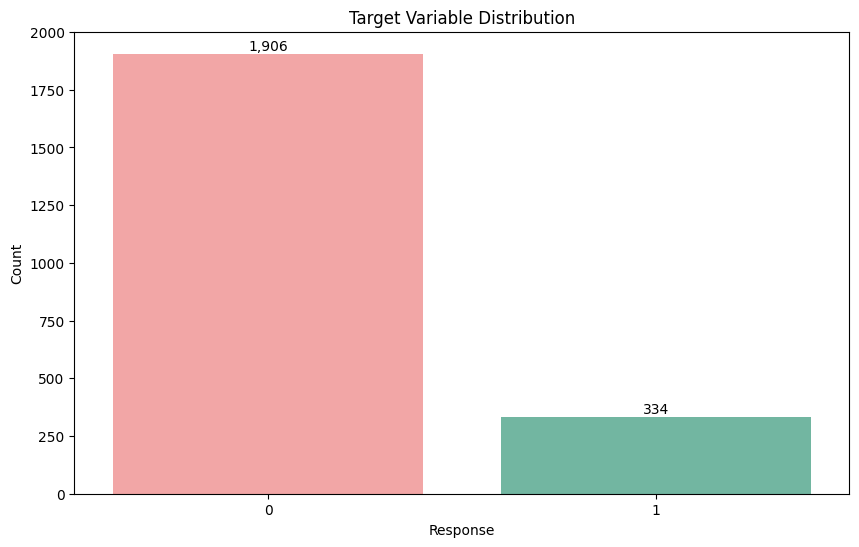

In [9]:
# Plot the distribution of the target variable
reusable_count_plotter(df_eda, col='Response', title='Target Variable Distribution', custom_palette={1: '#66c2a5', 0: '#ff9999'})

Similar to the observation from the statistics of the target variable, a large majority (1,906) did not accept the offer on the last campaign, highlighting a **class imbalance** that needs to be addressed in modeling.

## 3.2 Customer Demographics

### 3.2.1 Age

Age can be extracted from the `Year_Birth` column, using the the current year as the reference (2025)

In [10]:
# Extract the age of the customers from the date of birth
df_eda['Age'] = df_eda['Year_Birth'].apply(lambda x: 2025 - x)

# Check the statistics of the extracted age column
df_eda['Age'].describe()

count   2240.00
mean      56.19
std       11.98
min       29.00
25%       48.00
50%       55.00
75%       66.00
max      132.00
Name: Age, dtype: float64

In [11]:
def reusable_box_plotter_by_target(df, col, title, custom_palette, textsize=10):
    """
    Function to create a box plot for a specified column by the target variable in the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        col (str): The column name for which the box plot is to be created.
        title (str): The title of the plot.
        custom_palette (list): A list of colors for the plot.

    Returns:
        None
    """
    # Create a box plot for the specified column
    plt.figure(figsize=(14, 8))
    ax = sns.boxplot(x='Response', y=col, data=df, palette=custom_palette, hue='Response', dodge=False)

    # Calculate and annotate Q1, Q2, Q3 for each 'Response' group
    grouped = df.groupby('Response')[col]
    for i, (response, group) in enumerate(grouped):
        q1 = group.quantile(0.25)
        q2 = group.median()
        q3 = group.quantile(0.75)

        # Plot annotations slightly to the side of the box
        ax.text(i + 0.08, q1, f'Q1: {q1:,.2f}', ha='center', va='bottom', fontsize=textsize)
        ax.text(i + 0.08, q2, f'Q2: {q2:,.2f}', ha='center', va='bottom', fontsize=textsize)
        ax.text(i + 0.08, q3, f'Q3: {q3:,.2f}', ha='center', va='bottom', fontsize=textsize)

    plt.title(title)
    plt.xlabel("Response")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

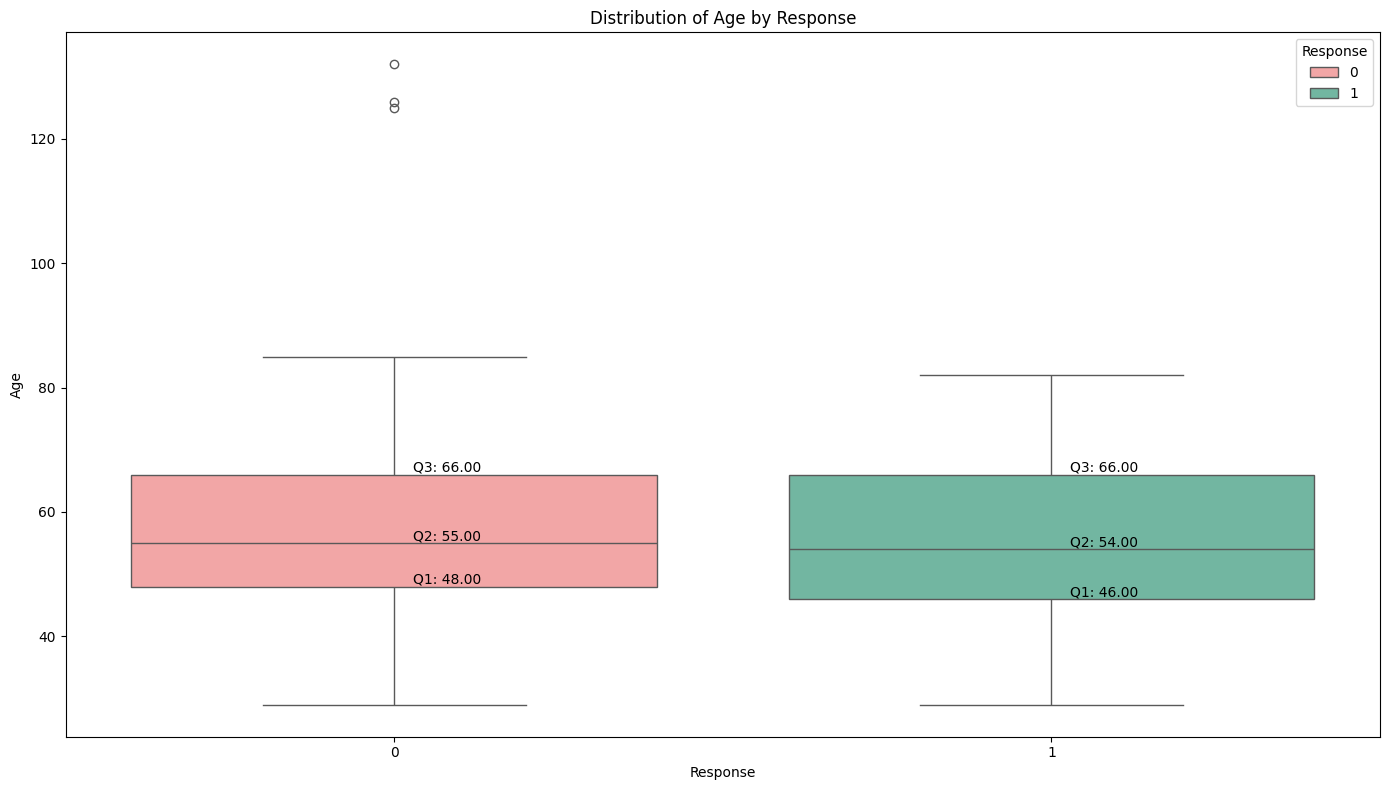

In [12]:
# Plot the distribution of Age with respect to the target variable
reusable_box_plotter_by_target(df_eda, col='Age', title='Distribution of Age by Response', custom_palette={1: '#66c2a5', 0: '#ff9999'})

The **distribution of age** for both clients who accepted the offer from the last campaign and those who didn't are **more or less the same**. 

**Outliers are present** in the upper portion of customers who rejected the offer on the last campaign, with ages **above 120**. Age beyond that range doesn't make sense given the average life expectancy of human. It might be better to **ignore these few outliers** during modelling.

### 3.2.2 Marital Status

In [13]:
# Check the value counts of the `Marital_Status` column
df_eda['Marital_Status'].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: count, dtype: int64

Three categories in `Marital_Status` column doesn't make sense, specifically the 'Alone', 'YOLO', and 'Absurd'. Since all of them are only 2 or 3 entries, it's better to filter them out and ignore them for both EDA and modelling.

For the marital status called 'Together', I will be assuming that they have a live-in partner, but not yet married.

In [14]:
# Filter out 'Alone', 'YOLO', and 'Absurd' categories from `Marital_Status`
df_eda = df_eda[~df_eda['Marital_Status'].isin(['Alone', 'YOLO', 'Absurd'])]
df_eda['Marital_Status'].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Name: count, dtype: int64

In [15]:
# Create another reusable function for count plots by target variable
def reusable_count_plotter_by_target(df, col, title, custom_palette):
    """
    Function to create a count plot for a specified column by the target variable in the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        col (str): The column name for which the count plot is to be created.
        title (str): The title of the plot.
        custom_palette (list): A list of colors for the plot.

    Returns:
        None
    """
    # Order the bar by the count of the column specified
    order = df[col].value_counts().index

    # Create a bar plot for the specified column
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=col, hue='Response', data=df, palette=custom_palette, order=order)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Response')

    # Annotate the actual numbers on the plot with commas for thousand places
    for p in ax.patches:
        height = p.get_height()
        if height > 0: 
            ax.annotate(f'{height:,.0f}', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.show()

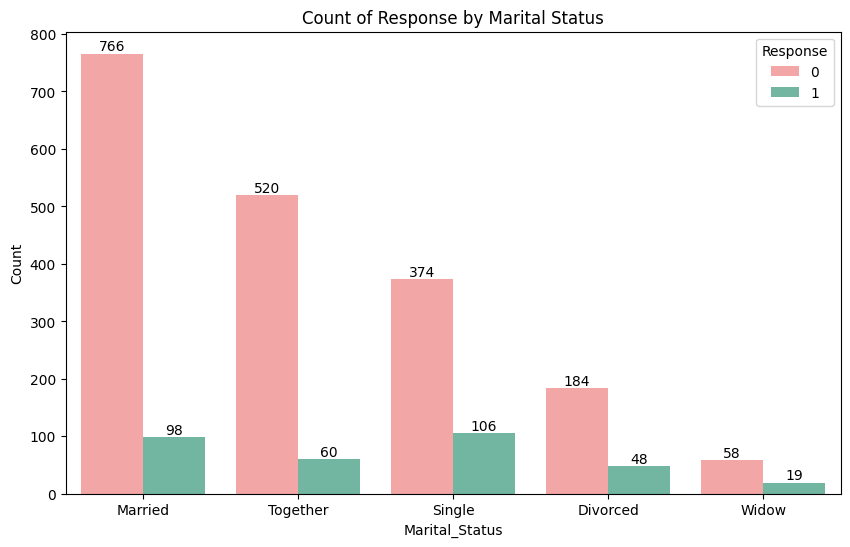

In [16]:
# Plot the count of people who accepted/rejected the offer by marital status
reusable_count_plotter_by_target(df_eda, col='Marital_Status', title='Count of Response by Marital Status', custom_palette={1: '#66c2a5', 0: '#ff9999'})

Although 'Married' has the higher value counts, it seems that the 'Single' category still has the highest number of customer who accepted the offer on the last campaign.

In order to clearly see which category has the highest acceptance rate, it's might be better to plot them with percentages instead of absolute values.

In [17]:
def reusable_pie_plotter_by_target(df, col, title, dim):
    """
    Function to create a pie chart for each category of a specified column in the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        col (str): The column name for which the pie chart is to be created.
        title (str): The title of the plot.
        dim (List): Dimensions for the subplots.

    Returns:
        None
    """
    # Calculate the acceptance rate for each category by the specified column
    acceptance_rate = df[df['Response'] == 1].groupby(col).size() / df.groupby(col).size()

    # Create pie charts for each category by the specified column
    fig, axes = plt.subplots(dim[0], dim[1], figsize=(18, 6))

    categories = acceptance_rate.index
    for i, category in enumerate(categories):
        sizes = [acceptance_rate[category], 1 - acceptance_rate[category]]
        labels = [1, 0]
        colors = ['#66c2a5', '#ff9999']
        explode = (0.1, 0)
        
        ax = axes[i % dim[0], i // dim[0]]  
        ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                    shadow=True, startangle=140)
        ax.axis('equal') 
        ax.set_title(f'Acceptance Rate for {category.capitalize()}')

    # Hide any unused axes
    if len(categories) < math.prod(axes.shape):
        for i in range(len(categories), math.prod(axes.shape)):
            ax = axes[i % dim[0], i // dim[0]]  
            ax.axis('off')

    plt.suptitle(title)
    plt.show()

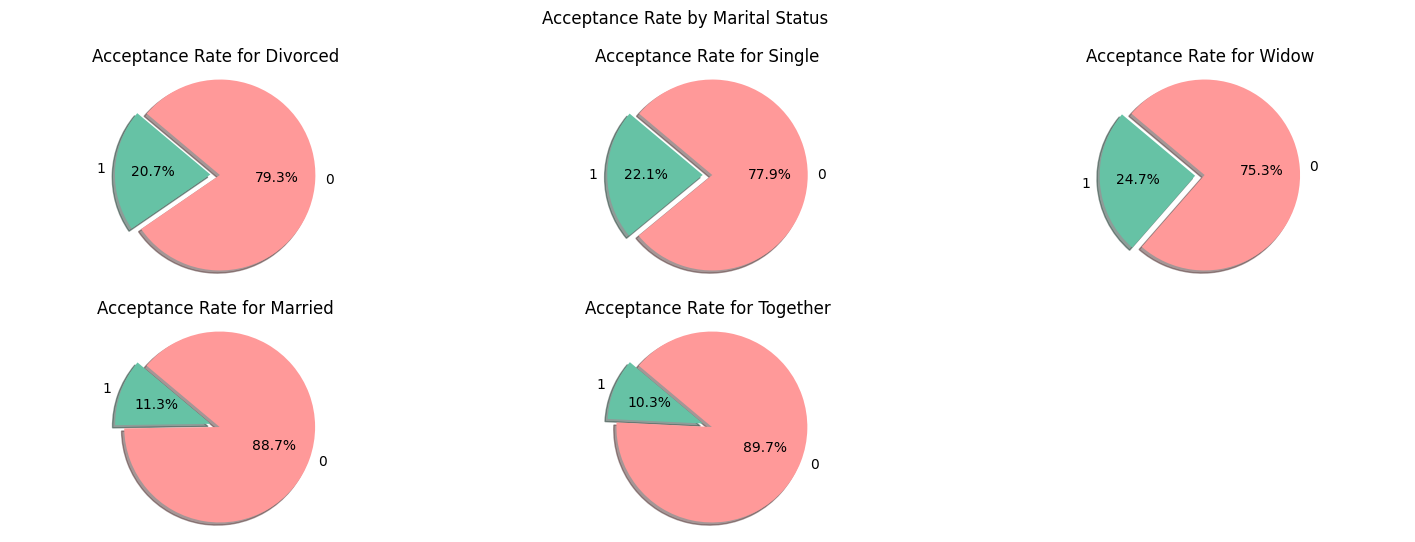

In [18]:
# Plot the acceptance rate for each marital status category
reusable_pie_plotter_by_target(df_eda, col='Marital_Status', title='Acceptance Rate by Marital Status', dim=[2,3])

Based on the acceptance rate per marital status category, **'Widow'**, **'Single'**, and **'Divorced'** categories have the **highest acceptance rates**, with all them **exceeding 20%**, which is around 10% greater than the other categories ('Married', 'Together'). 

**Recommendation:**
<br>
*Allocate more effort and resources for individuals with marital status as 'Widow', 'Single', and 'Divorced'.*

### 3.2.3 Educational Attainment

In [19]:
# Check the value counts of the `Education` column
df_eda['Education'].value_counts()

Education
Graduation    1125
PhD            483
Master         368
2n Cycle       203
Basic           54
Name: count, dtype: int64

According to [european education system](https://eurydice.eacea.ec.europa.eu/national-education-systems/republic-north-macedonia/second-cycle-programmes#:~:text=A%20student%20that%20completes%20the,Master%20of%20Arts%20(MA).), '2n Cycle' also means Master's Degree. Change '2n Cycle' values to 'Master', as they are technically the same. Do the same when cleaning for modelling as well.

In [20]:
# Change the value '2n Cycle' in the `Education` column to 'Master'
df_eda['Education'] = df_eda['Education'].replace({'2n Cycle': 'Master'})
df_eda['Education'].value_counts()

Education
Graduation    1125
Master         571
PhD            483
Basic           54
Name: count, dtype: int64

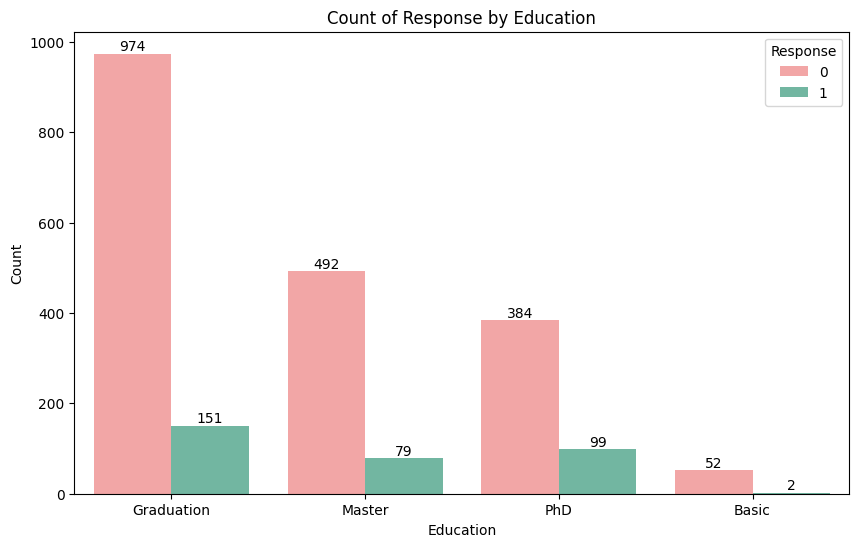

In [21]:
# Plot the count of people who accepted/rejected the offer by educational attainment
reusable_count_plotter_by_target(df_eda, col='Education', title='Count of Response by Education', custom_palette={1: '#66c2a5', 0: '#ff9999'})

In terms of absolute values, 'Graduation' segment have the highest number of customers who accepted the offer in the last campaign. Similar to the Marital Status, it might be better to focus on the acceptance rate instead.

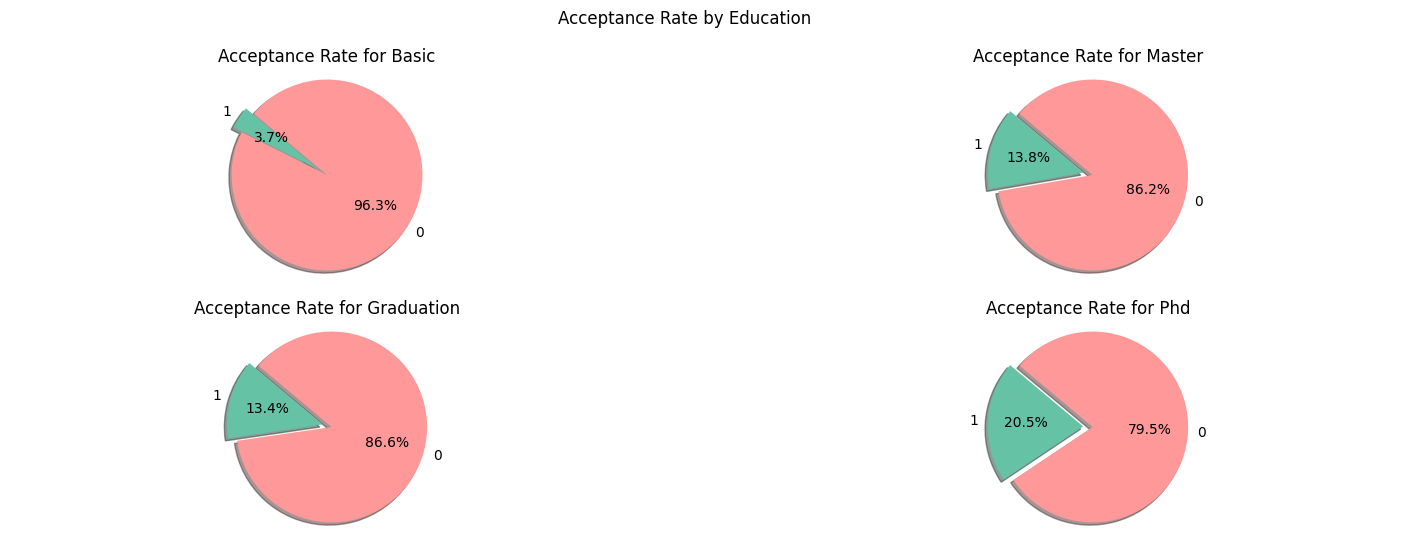

In [22]:
# Plot the acceptance rate for each educational attainment category
reusable_pie_plotter_by_target(df_eda, col='Education', title='Acceptance Rate by Education', dim=[2,2])

Based on the acceptance rate, people who completed **'Phd'** have the **highest acceptance rate** at 20.5%. 

**Recommendation:**<br>
*Allocate more campaign resources and efforts to customers who have completed their PhD.*

### 3.2.4 Income

In [23]:
# Check the basic statistics of the `Income` column
df_eda['Income'].describe()

count     2209.00
mean     52243.98
std      25198.48
min       1730.00
25%      35246.00
50%      51390.00
75%      68627.00
max     666666.00
Name: Income, dtype: float64

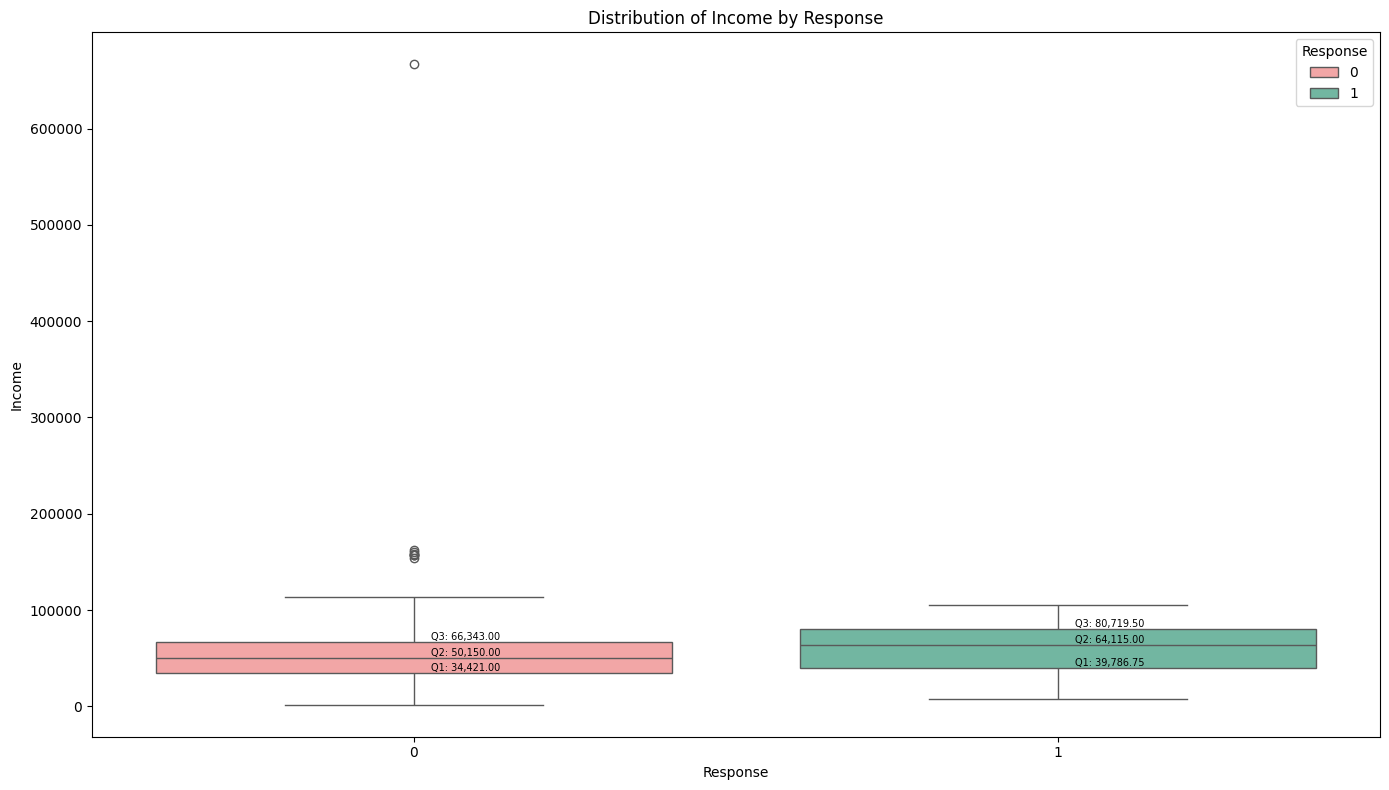

In [24]:
# Plot the distribution of Age with respect to the target variable
reusable_box_plotter_by_target(df_eda, col='Income', title='Distribution of Income by Response', custom_palette={1: '#66c2a5', 0: '#ff9999'}, textsize=7)

Outliers are present in `Response`=0, making the box plots really small. Since we're mainly interested on the distribution of most of the customers, it might be better to remove the outliers for this visualization, to make it more visually appealing. 

Though, it is good to take note that there's some outliers for customers who rejected the offer from the last campaign, with income higher than 100,000. 

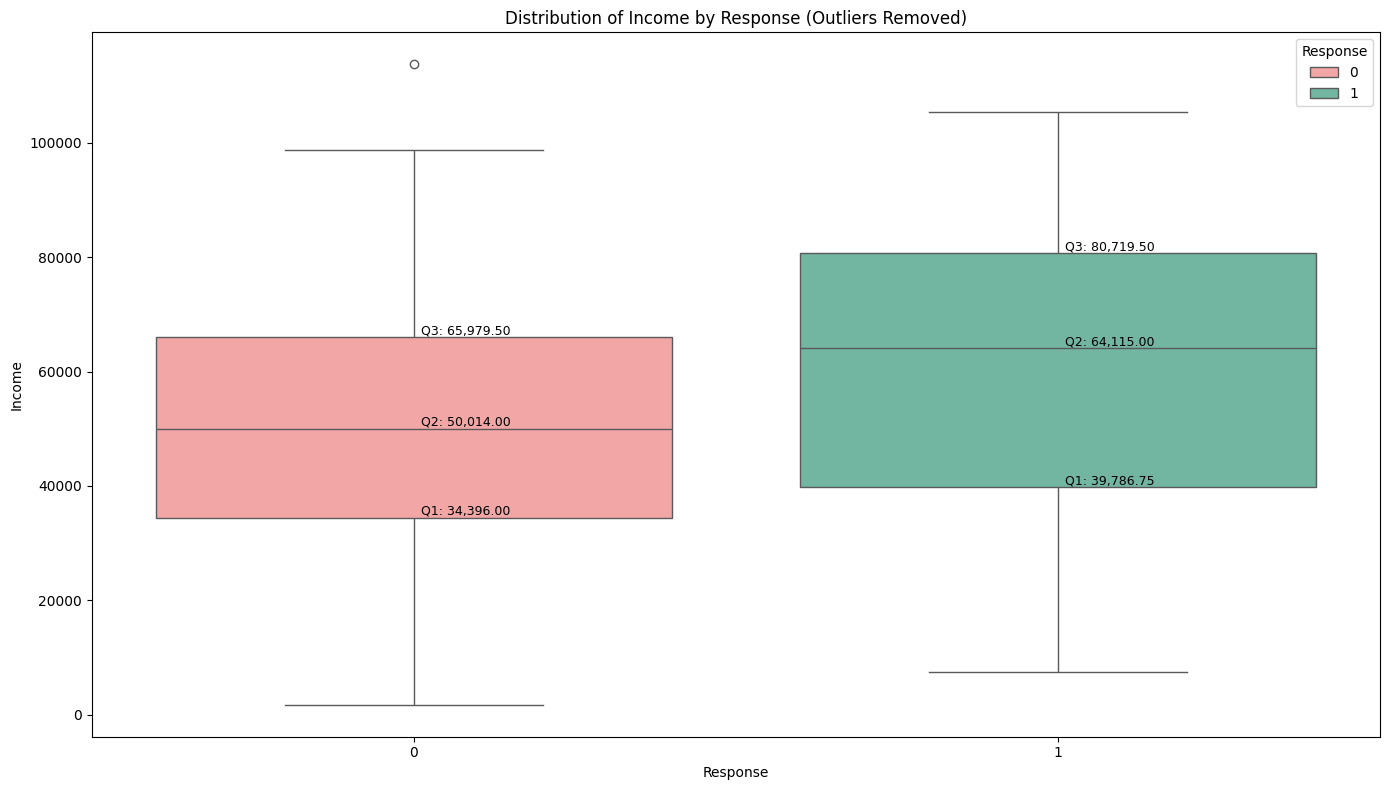

In [25]:
# Remove the outliers using the IQR method
Q1 = df_eda['Income'].quantile(0.25)
Q3 = df_eda['Income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_eda_income = df_eda[(df_eda['Income'] >= lower_bound) & (df_eda['Income'] <= upper_bound)]

# Plot the distribution of Income with respect to the target variable after removing outliers
reusable_box_plotter_by_target(df_eda_income, col='Income', title='Distribution of Income by Response (Outliers Removed)', custom_palette={1: '#66c2a5', 0: '#ff9999'}, textsize=9)

In general, people who accepted the offer in the last campaign possesses a **higher income** than those who didn't. Based on the statistics of the income, a **larger portion** of the people who accepted the offer have **income higher than the average** (~52k).

**Recommendation:**
<br>
*In launching a new offer, prioritize customers with higher income as they tend to accept the deals more*

### 3.2.5 Presence of Children

In [26]:
# Create a new column for the number of children
df_eda['Num_Children'] = df_eda['Kidhome'] + df_eda['Teenhome']

#Convert the `Num_Children` column to a categorical variable
df_eda['Num_Children'] = df_eda['Num_Children'].astype(str)

# Check the value counts of the `Num_Children` column
df_eda['Num_Children'].value_counts()

Num_Children
1    1125
0     636
2     419
3      53
Name: count, dtype: int64

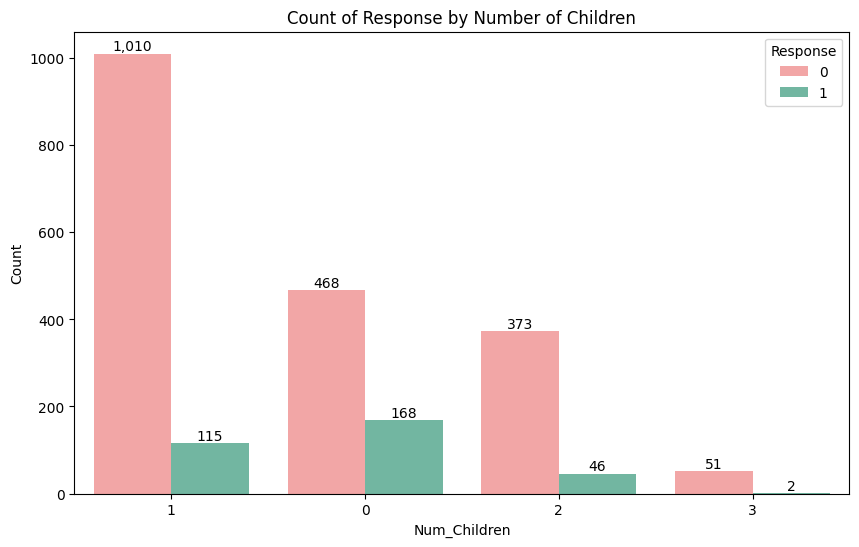

In [27]:
# Plot the count of people who accepted/rejected the offer by the number of children
reusable_count_plotter_by_target(df_eda, col='Num_Children', title='Count of Response by Number of Children', custom_palette={1: '#66c2a5', 0: '#ff9999'})

People without children has the highest absolute value of people who accepted the offer in the last campaign. Let's also take a look at the acceptance rate.

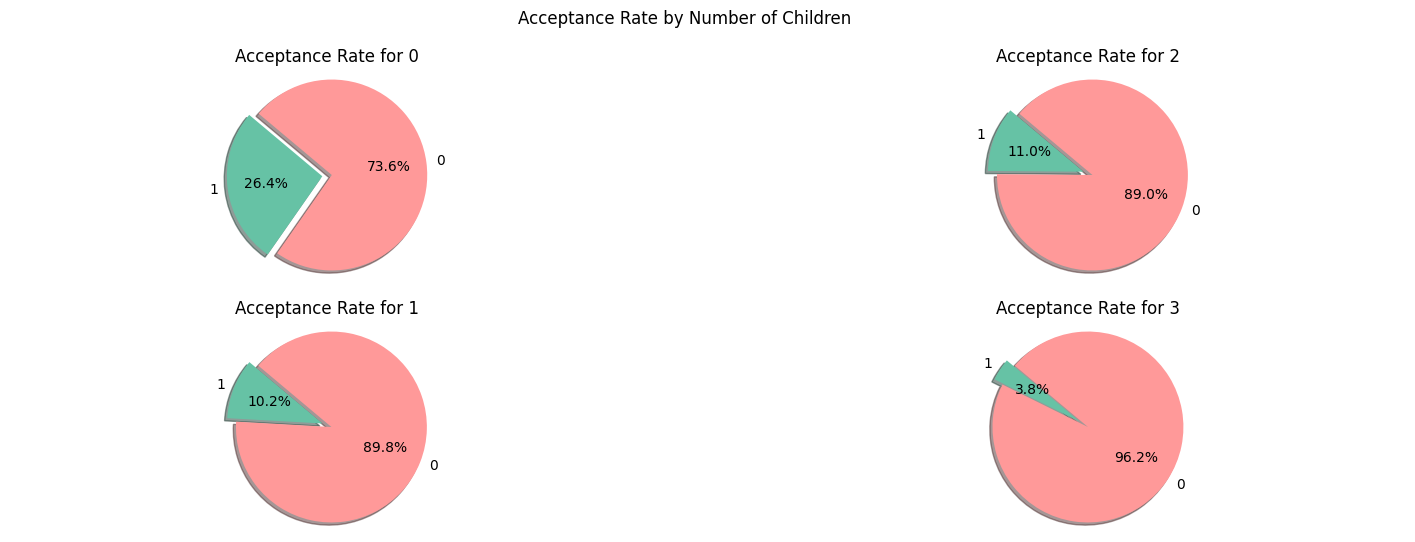

In [28]:
# Plot the acceptance rate for each number of children category
reusable_pie_plotter_by_target(df_eda, col='Num_Children', title='Acceptance Rate by Number of Children', dim=[2,2])

From the acceptance rate, customers without children is still at the top.

**Recommendation:**
<br>
*Allocate more campaign resources and efforts to customers without children*

## 3.3 Spending Behavior

### 3.3.1 Total Spend

In [29]:
# Sum all features that are related to spending
df_eda['Total_Spend'] = df_eda[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

df_eda['Total_Spend'].describe()

count   2233.00
mean     605.90
std      602.70
min        5.00
25%       68.00
50%      396.00
75%     1045.00
max     2525.00
Name: Total_Spend, dtype: float64

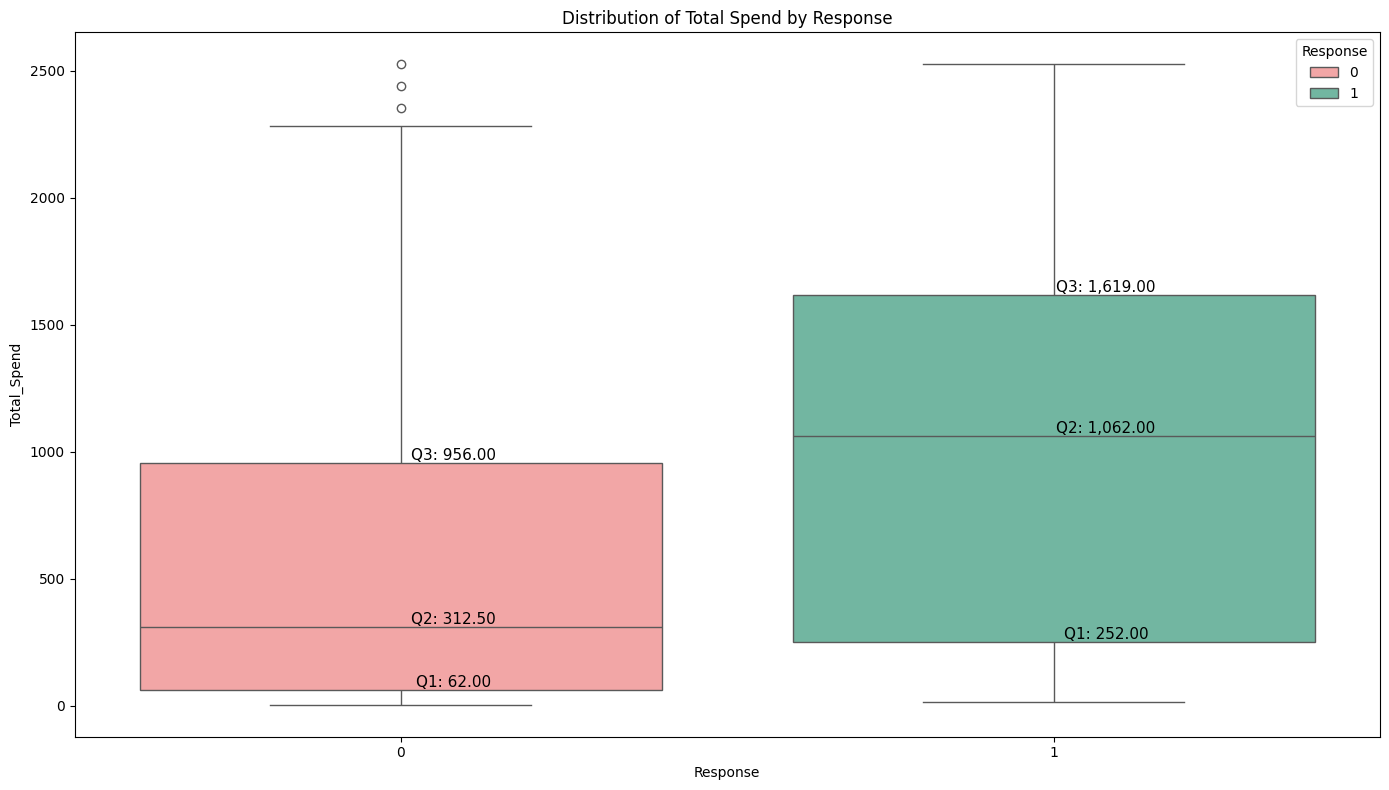

In [30]:
# Plot the box plot for 'Total_Spend' with respect to the target variable
reusable_box_plotter_by_target(df_eda, col='Total_Spend', title='Distribution of Total Spend by Response', custom_palette={1: '#66c2a5', 0: '#ff9999'}, textsize=11)

People who **spend more** on company products also tends to **accept the offer** from the marketing campaigns of the company. Based from the statistics, a **larger portion** of the people who accepted the offer in the last campaign have a **total spending higher than the average** (~606).

**Recommendation:**
<br>
*In launching a new offer, prioritize customers with higher spending on company products.*

### 3.3.2 Number of Purchases

In [31]:
# Total number of purchases
df_eda['Total_Purchases'] = df_eda[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)
df_eda['Total_Purchases'].describe()

count   2233.00
mean      14.86
std        7.68
min        0.00
25%        8.00
50%       15.00
75%       21.00
max       44.00
Name: Total_Purchases, dtype: float64

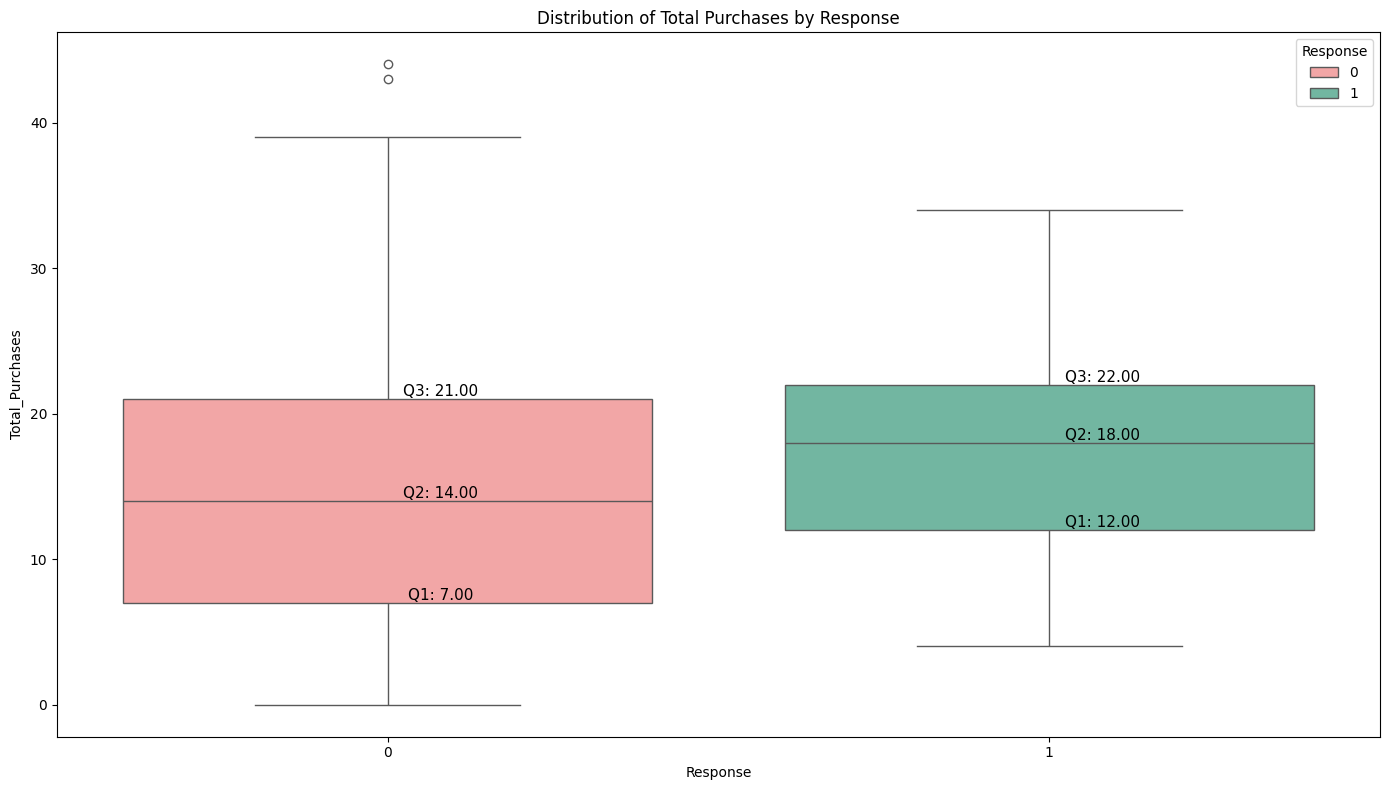

In [32]:
# Plot the box plot for 'Total_Purchases' with respect to the target variable
reusable_box_plotter_by_target(df_eda, col='Total_Purchases', title='Distribution of Total Purchases by Response', custom_palette={1: '#66c2a5', 0: '#ff9999'}, textsize=11)

Consistent with the spending, people who accepted the offer in the last campaign tends to make purchases more often than those who didn't. Moreover, the majority of people who accepted the offer in the last campaign has the number of purchases higher than the average (~15).

**Recommendation:**
<br>
*In launching a new offer, prioritize customers with higher number of purchases on company products.*

### 3.3.3 Recency

In [33]:
# Check the basic statistics of the `Recency` column
df_eda['Recency'].describe()

count   2233.00
mean      49.17
std       28.96
min        0.00
25%       24.00
50%       50.00
75%       74.00
max       99.00
Name: Recency, dtype: float64

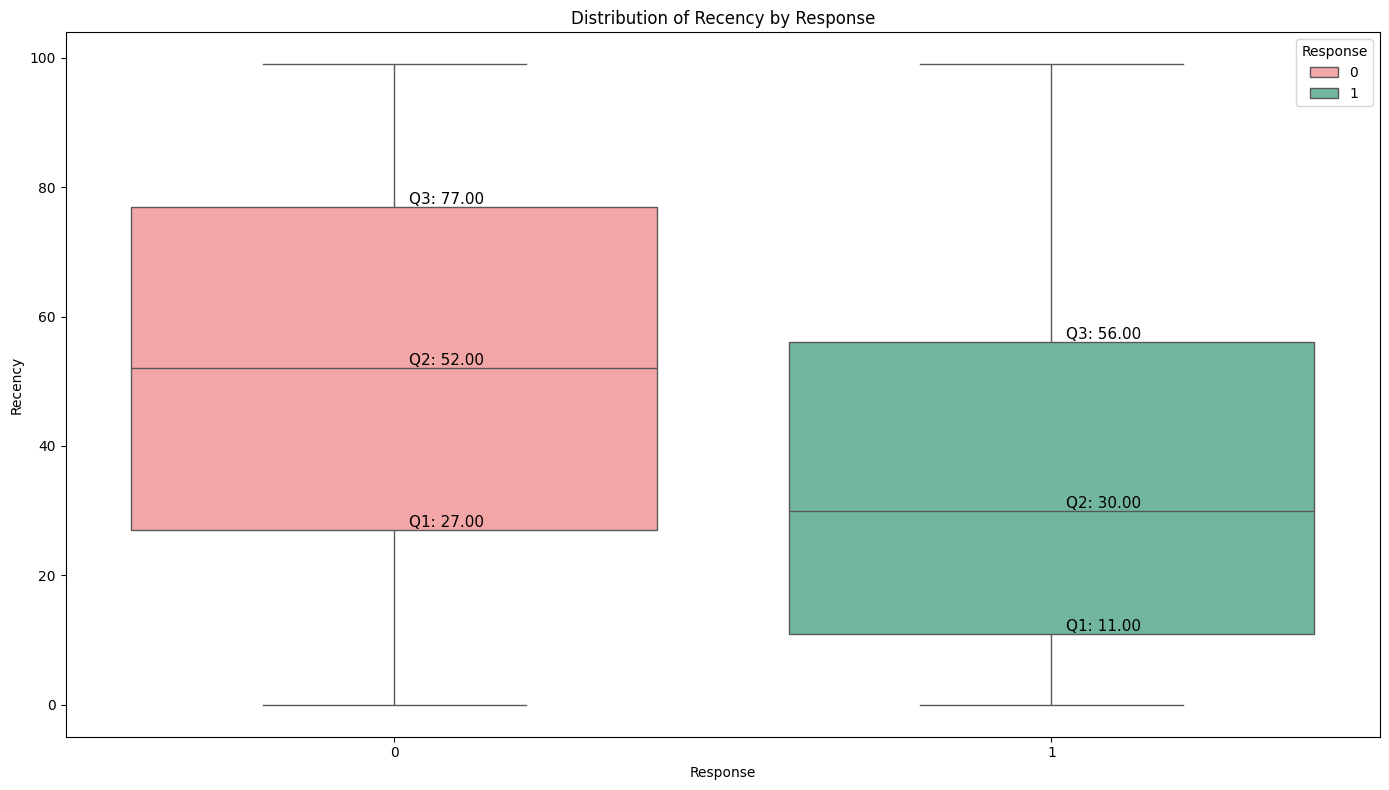

In [34]:
# Plot the box plot for 'Recency' with respect to the target variable
reusable_box_plotter_by_target(df_eda, col='Recency', title='Distribution of Recency by Response', custom_palette={1: '#66c2a5', 0: '#ff9999'}, textsize=11)

People who accepted the offer in the last campaign have made their **recent purchase in fewer days** than those who didn't. In addition to that, given that the mean of the `Recency` is ~49, a **large majority** of customers who accepted the last offer have made their recent purchase in **fewer days than the average**.

**Recommendation:**
<br>
*Prioritize loyal customers with smaller recency*

Let's also check the Number of Website Visit of the Customer in the last month

In [35]:
# Check the statistics of the `NumWebVisitsMonth` column
df_eda['NumWebVisitsMonth'].describe()

count   2233.00
mean       5.32
std        2.43
min        0.00
25%        3.00
50%        6.00
75%        7.00
max       20.00
Name: NumWebVisitsMonth, dtype: float64

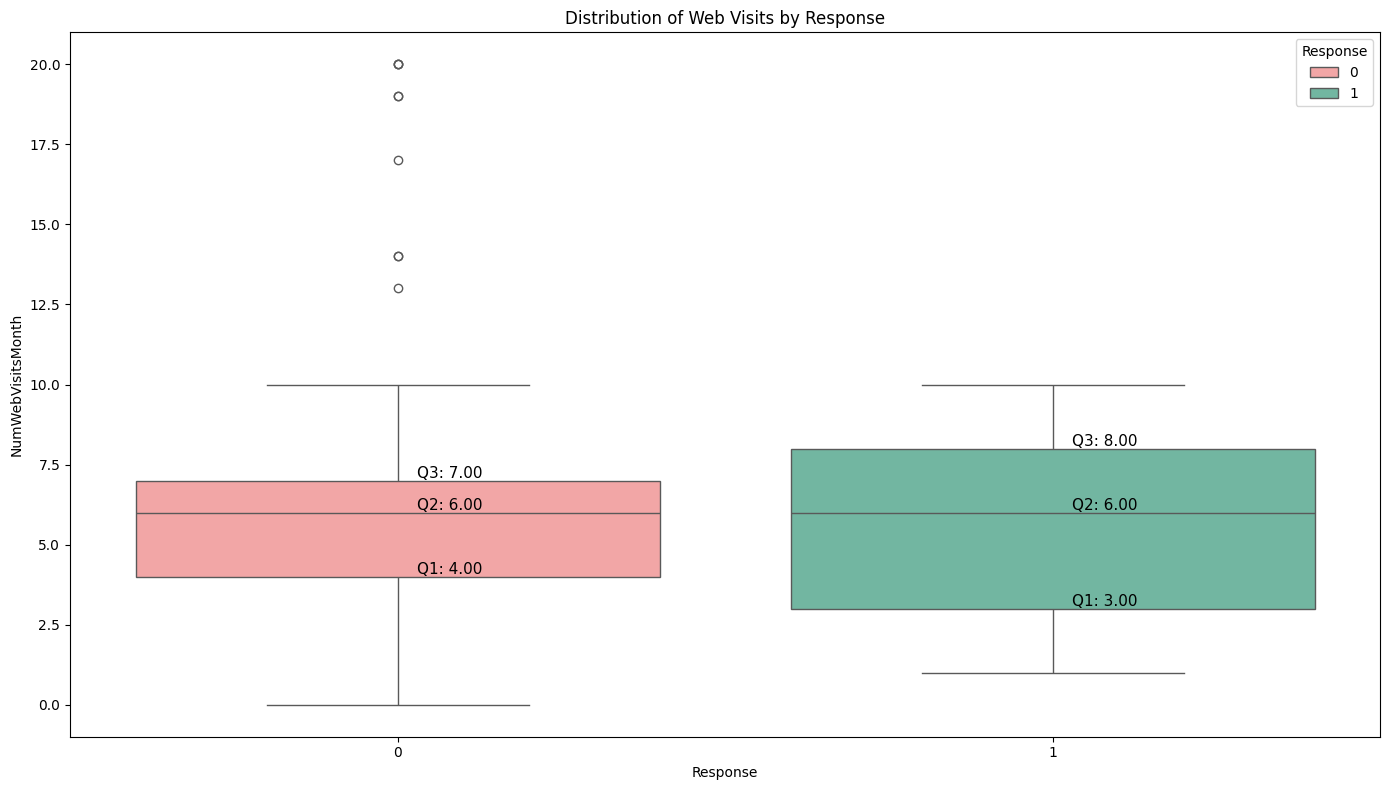

In [36]:
# Plot the box plot for 'NumWebVisitsMonth' with respect to the target variable
reusable_box_plotter_by_target(df_eda, col='NumWebVisitsMonth', title='Distribution of Web Visits by Response', custom_palette={1: '#66c2a5', 0: '#ff9999'}, textsize=11)

The **distribution** of the target variable categories is **more or less the same**, though the people of accepted the offer in the last campaign have a wider interquartile range.

# 4. Data Preparation for Modelling

In [37]:
# Create a copy of the dataset for modelling
df_model = df.copy()

# Show a sample of the dataset
df_model.sample(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
2140,5623,1980,Master,Married,31535.00,1,0,9/26/13,95,15,4,13,0,0,19,1,1,1,2,7,0,0
1084,3099,1970,Graduation,Divorced,44267.00,1,1,2/25/13,48,183,5,65,3,5,49,5,5,2,4,9,0,0
2141,4789,1953,Graduation,Together,80812.00,0,0,9/17/13,95,769,22,500,210,143,33,1,4,8,5,2,0,0
1599,7761,1978,2n Cycle,Together,38702.00,1,0,2013-01-08 00:00:00,71,13,11,24,13,8,40,2,3,0,4,6,0,0
126,2404,1976,Graduation,Married,53359.00,1,1,5/27/13,4,173,4,30,3,6,41,4,5,1,4,7,0,0
1861,7004,1984,Graduation,Single,11012.00,1,0,3/16/13,82,24,3,26,7,1,23,3,3,1,2,9,0,0
438,9596,1980,PhD,Single,65295.00,0,0,12/23/13,19,365,32,117,34,110,6,1,3,3,13,2,0,0
1096,4345,1964,2n Cycle,Single,NaN,1,1,2014-12-01 00:00:00,49,5,1,9,2,0,4,1,1,0,2,7,0,0
1827,7732,1978,Graduation,Married,64813.00,1,0,2014-02-01 00:00:00,81,293,0,124,179,97,52,1,7,2,10,5,0,0
224,3524,1971,Master,Single,39763.00,1,0,2013-04-08 00:00:00,9,80,1,60,4,6,16,2,5,1,2,9,1,0


From the exploration of the data, the following are the features that needs cleaning:
- `Year_Birth`: convert to `Age`, remove entries with age higher than 120
- `Marital_Status`: filter out entries with values that doesn't make sense ('Absurd', 'YOLO', 'Alone')
- `Education`: convert '2n Cycle' to 'Master', as they are technically the same
- `Dt_Customer`: it might be better to convert this on how many years has the customer been in the company (`Customer_Tenure`)
- `Income`: there is 24 missing values, the customer's income is very hard to assume, hence it would be better to drop those entries since the amount is minimal
- `ID`: Drop this column as it doesn't have any meaningful relationship with the target variable

Moreover, from the data quality check at the beginning, there is 182 duplicated entries. Drop these entries.

## 4.1 Drop Duplicates

In [38]:
# Drop the duplicates in the dataset
df_model = df_model.drop_duplicates(subset=[x for x in df_model.columns if x != 'ID'])

# Check for duplicates again
print("Duplicates after dropping:")
df_model.duplicated(subset=[x for x in df_model.columns if x != 'ID']).value_counts()


Duplicates after dropping:


False    2058
Name: count, dtype: int64

No more duplicates found in the dataset

## 4.2 Drop Missing Values (`Income`)

In [39]:
# Drop the missing values in the `Income` column
df_model = df_model.dropna(subset=['Income'])

# Check the number of missing values in the dataset
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2034 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2034 non-null   int64  
 1   Year_Birth           2034 non-null   int64  
 2   Education            2034 non-null   object 
 3   Marital_Status       2034 non-null   object 
 4   Income               2034 non-null   float64
 5   Kidhome              2034 non-null   int64  
 6   Teenhome             2034 non-null   int64  
 7   Dt_Customer          2034 non-null   object 
 8   Recency              2034 non-null   int64  
 9   MntWines             2034 non-null   int64  
 10  MntFruits            2034 non-null   int64  
 11  MntMeatProducts      2034 non-null   int64  
 12  MntFishProducts      2034 non-null   int64  
 13  MntSweetProducts     2034 non-null   int64  
 14  MntGoldProds         2034 non-null   int64  
 15  NumDealsPurchases    2034 non-null   int64 

No more missing values found in the dataset

## 4.3 Feature Engineering

### 4.3.1 `Year_Birth` to `Age`

In [40]:
# Convert the `Year_Birth` column to `Age` and drop the `Year_Birth` column
df_model['Age'] = df_model['Year_Birth'].apply(lambda x: 2025 - x)
df_model = df_model.drop(columns=['Year_Birth'])

# Check the sample of the dataset after dropping the `Year_Birth` column
df_model.sample(10)

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age
1334,701,Graduation,Married,73691.00,0,1,2013-06-11 00:00:00,58,707,21,250,85,43,73,2,6,2,8,2,0,0,54
986,2694,Graduation,Married,42664.00,0,1,3/18/14,44,21,0,3,0,0,0,1,1,0,3,6,0,0,58
836,942,Graduation,Single,39660.00,1,0,2012-08-08 00:00:00,36,139,13,78,20,13,36,3,7,1,3,9,1,0,43
776,8842,Graduation,Widow,30372.00,1,1,12/25/12,33,15,0,12,7,3,7,3,2,0,3,7,0,0,54
336,5929,PhD,Married,37401.00,1,0,2014-06-05 00:00:00,14,19,3,19,3,1,3,2,2,0,3,7,0,0,52
1179,2698,Graduation,Single,47025.00,0,1,2013-07-11 00:00:00,52,254,7,108,20,0,26,3,6,3,5,6,0,0,49
1839,2002,Graduation,Divorced,71964.00,0,0,5/20/13,81,587,51,932,180,34,86,1,5,6,5,3,0,0,67
42,1524,2n Cycle,Single,81698.00,0,0,2013-01-03 00:00:00,1,709,45,115,30,160,45,1,8,2,5,5,1,0,42
1501,7409,Graduation,Together,53187.00,1,0,10/26/13,66,211,2,30,7,7,10,2,4,1,6,5,0,0,55
2075,5631,Graduation,Single,49767.00,0,0,2013-02-05 00:00:00,92,202,47,197,55,42,149,1,5,4,8,4,0,0,34


Let's filter out the age that doesn't make sense, i.e., age that is above 120 years old

In [41]:
# Filter out `Age` values above 120
df_model = df_model[df_model['Age'] <= 120]

# Check the basic statistics of the `Age` column
df_model['Age'].describe()

count   2031.00
mean      56.09
std       11.66
min       29.00
25%       48.00
50%       55.00
75%       66.00
max       85.00
Name: Age, dtype: float64

### 4.3.2 `Marital_Status`

In [42]:
# Drop the 'Alone', 'YOLO', and 'Absurd' categories from `Marital_Status`
df_model = df_model[~df_model['Marital_Status'].isin(['Alone', 'YOLO', 'Absurd'])]

# Check the value counts of the `Marital_Status` column
df_model['Marital_Status'].value_counts()

Marital_Status
Married     788
Together    513
Single      438
Divorced    215
Widow        70
Name: count, dtype: int64

### 4.3.3 `Education`

In [43]:
# Convert the '2n Cycle' value in the `Education` column to 'Master'
df_model['Education'] = df_model['Education'].replace({'2n Cycle': 'Master'})

# Check the value counts of the `Education` column
df_model['Education'].value_counts()

Education
Graduation    1017
Master         517
PhD            441
Basic           49
Name: count, dtype: int64

### 4.3.4 `Dt_Customer` to `Customer_Tenure`

In [44]:
# Check the first few rows of the dataset for `Dt_Customer` column
df_model['Dt_Customer'].head(10)

0                 6/16/14
1                 6/15/14
2                 5/13/14
3     2014-11-05 00:00:00
4     2014-08-04 00:00:00
5                 3/17/14
6                 1/29/14
7                 1/18/14
8     2014-11-01 00:00:00
10               12/27/13
Name: Dt_Customer, dtype: object

In [45]:
# Unify the date format in the `Dt_Customer` column
unified_date_format = pd.to_datetime(df_model['Dt_Customer'], dayfirst=False, errors='coerce')

# Check the first few samples of the dataset after unifying the date format
unified_date_format.head(10)

0    2014-06-16
1    2014-06-15
2    2014-05-13
3    2014-11-05
4    2014-08-04
5    2014-03-17
6    2014-01-29
7    2014-01-18
8    2014-11-01
10   2013-12-27
Name: Dt_Customer, dtype: datetime64[ns]

In [46]:
# Extract how long the customer has been with the company in terms of years
df_model['Customer_Tenure'] = round((pd.to_datetime('2025-05-01') - unified_date_format).dt.days / 365, 2)

# Drop the `Dt_Customer` column
df_model = df_model.drop(columns=['Dt_Customer'])

# Check the statistics of the `Customer_Tenure` column
df_model['Customer_Tenure'].describe()

count   2024.00
mean      11.81
std        0.64
min       10.41
25%       11.33
50%       11.81
75%       12.28
max       13.32
Name: Customer_Tenure, dtype: float64

Let's take a look at the engineered features

In [47]:
# Check a sample of the dataset
df_model.sample(10)

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Customer_Tenure
824,10757,PhD,Divorced,28420.00,1,0,36,4,2,5,2,0,0,1,1,0,2,6,0,0,58,11.36
85,3878,Master,Single,31859.00,1,0,3,3,4,7,15,8,11,1,1,0,3,7,0,0,45,11.18
1396,3389,Graduation,Married,69016.00,0,1,61,726,53,363,123,107,161,4,8,9,13,5,0,0,55,12.45
723,9478,Graduation,Single,66503.00,1,0,30,91,64,128,65,3,50,2,4,3,6,3,0,0,40,12.72
89,3896,Graduation,Married,27255.00,1,0,3,22,1,11,0,1,2,1,1,0,3,7,0,0,41,11.81
198,10669,Graduation,Married,54386.00,0,1,8,277,21,64,62,21,25,2,3,2,10,3,0,0,44,11.96
1639,7247,Graduation,Widow,47916.00,0,1,72,505,0,26,0,0,75,5,7,4,6,6,0,0,65,12.45
1232,3706,Graduation,Single,28647.00,1,0,54,19,8,29,0,12,26,1,2,2,2,7,1,0,47,11.70
1036,4653,Graduation,Together,42011.00,1,0,46,131,0,16,2,1,39,4,3,1,4,8,0,0,47,12.11
2038,7422,Graduation,Single,46923.00,1,0,90,85,44,54,102,78,6,3,5,1,7,7,0,0,38,12.70


## 4.4 Feature Selection

### 4.4.1 Correlation Matrix

To check if there's any data leakage within the data, let's take a look at the features' correlation matrix.

For the correlation matrix to work, convert the categorical features into numerical using LabelEncoder.

In [48]:
# Create a copy of the dataset for correlation analysis
df_le = df_model.copy()

# Use LabelEncoder to encode categorical variables
le = LabelEncoder()
for col in df_le.select_dtypes(include=['object']).columns:
    df_le[col] = le.fit_transform(df_le[col])

# Check the first few rows of the dataset after encoding categorical variables
df_le.head(10)

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Customer_Tenure
0,1826,1,0,84835.00,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,55,10.88
1,1,1,2,57091.00,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0,64,10.88
2,10476,1,1,67267.00,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,67,10.98
3,1386,1,3,32474.00,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,58,10.49
4,5371,1,2,21474.00,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,36,10.75
5,7348,3,2,71691.00,0,0,0,336,130,411,240,32,43,1,4,7,5,2,1,0,67,11.13
6,4073,2,1,63564.00,0,0,0,769,80,252,15,34,65,1,10,10,7,6,1,0,71,11.26
7,1991,1,3,44931.00,0,1,0,78,0,11,0,0,7,1,2,1,3,5,0,0,58,11.29
8,4047,3,1,65324.00,0,1,0,384,0,102,21,32,5,3,6,2,9,4,0,0,71,10.50
10,2079,2,1,81044.00,0,0,0,450,26,535,73,98,26,1,5,6,10,1,0,0,78,11.35


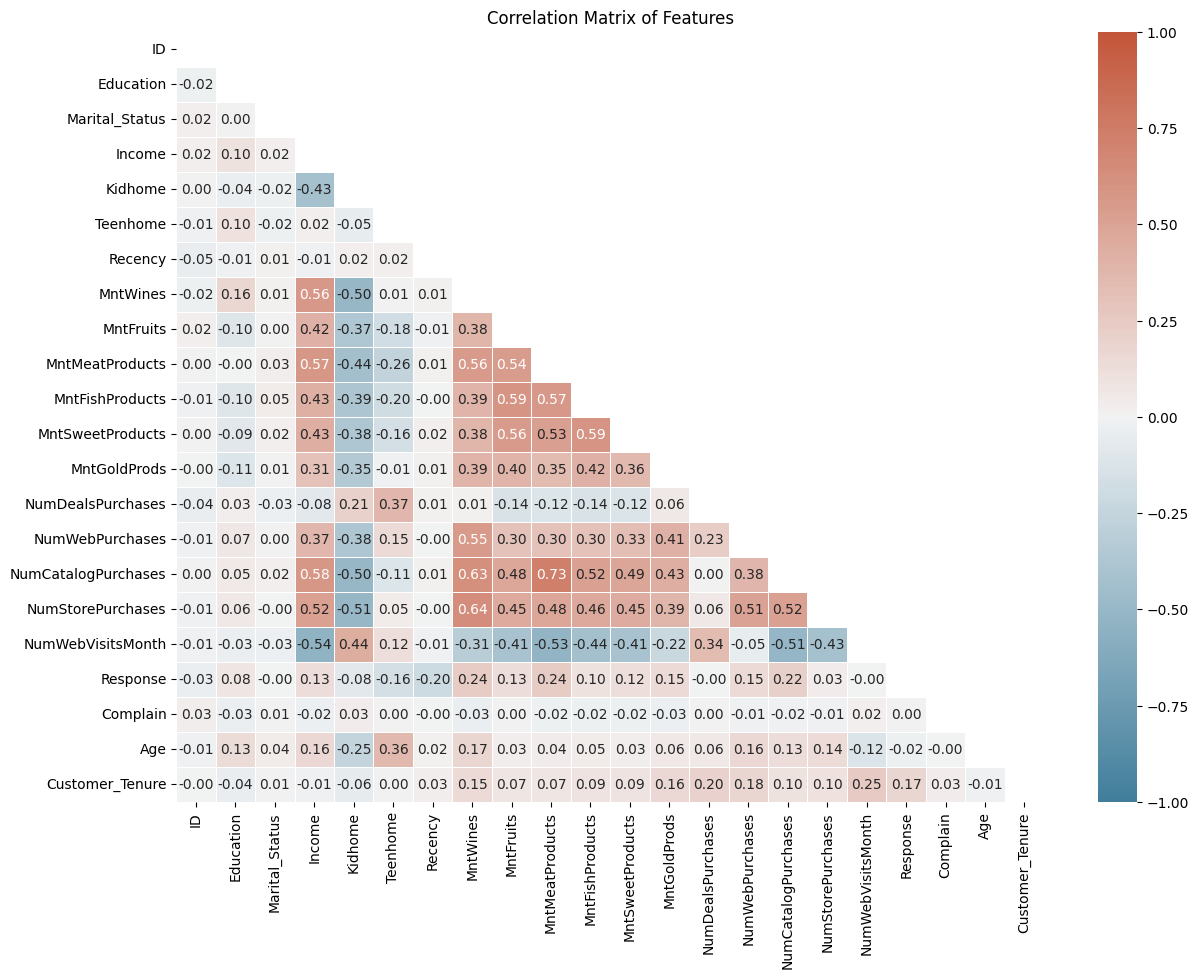

In [49]:
# Extract the correlation matrix
corr_matrix = df_le.corr()

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a custom diverging color palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, fmt=".2f", center=0, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

From the correlation matrix, there's **no features** that has a correlation **above $\pm$ 0.8** with the **target variable**, with the closest at 0.24, implying that there might be **no data leakage** between the features and the target variable.

Moreover, there's also **multiple features** with almost **no correlation** with the target variable, notably the `Marital_Status`, `NumDealsPurchases`, & `NumWebVisitsMonth`. However, since the target variable is binary and not continuous, correlation matrix isn't really very indicative that the features with no correlation to the target variable will be useless for predictive modelling.

### 4.4.2 Mutual Information

Since mutual information algorithm also requires numerical inputs, we'll reuse the dataframe from the correlation analysis

In [50]:
# Check the first few rows of the dataset
df_le.head(10)

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Customer_Tenure
0,1826,1,0,84835.00,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,55,10.88
1,1,1,2,57091.00,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0,64,10.88
2,10476,1,1,67267.00,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,67,10.98
3,1386,1,3,32474.00,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,58,10.49
4,5371,1,2,21474.00,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,36,10.75
5,7348,3,2,71691.00,0,0,0,336,130,411,240,32,43,1,4,7,5,2,1,0,67,11.13
6,4073,2,1,63564.00,0,0,0,769,80,252,15,34,65,1,10,10,7,6,1,0,71,11.26
7,1991,1,3,44931.00,0,1,0,78,0,11,0,0,7,1,2,1,3,5,0,0,58,11.29
8,4047,3,1,65324.00,0,1,0,384,0,102,21,32,5,3,6,2,9,4,0,0,71,10.50
10,2079,2,1,81044.00,0,0,0,450,26,535,73,98,26,1,5,6,10,1,0,0,78,11.35


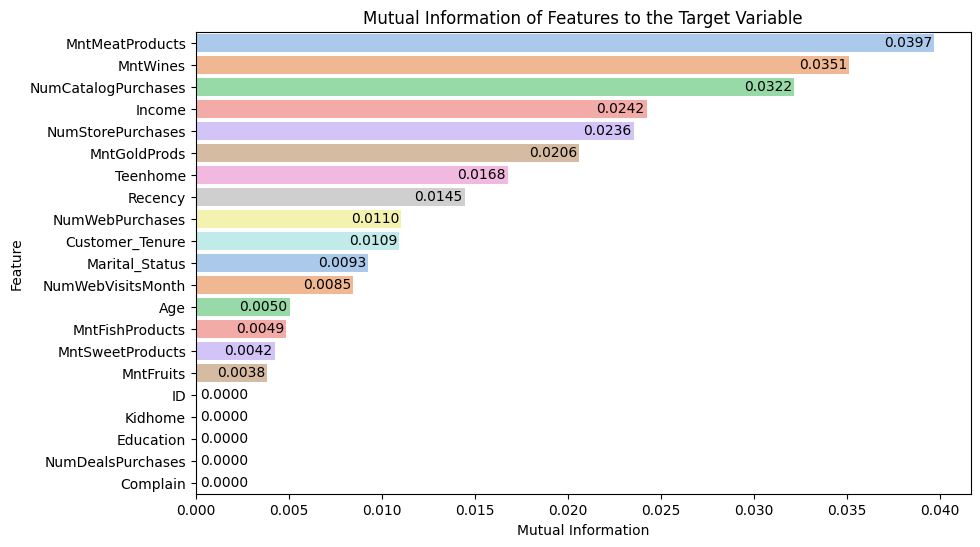

In [51]:
# Separate the features and target variable
X = df_le.drop(columns='Response')
y = df_le['Response']

# Calculate mutual information
mi = mutual_info_classif(X, y, discrete_features='auto', random_state=0)

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Plot mutual information
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Mutual Information', y='Feature', data=mi_df, hue='Feature', palette='pastel')
plt.title('Mutual Information of Features to the Target Variable')

# Annotate the values beside the bars
for index, value in enumerate(mi_df['Mutual Information']):
    if value - 0.0025 > 0:
        plt.text(value - 0.0027, index, f'{value:.4f}', va='center')
    else:
        plt.text(value + 0.00025, index, f'{value:.4f}', va='center')

plt.show()

According to the Mutual Information plot, `ID`, `Kidhome`, `Education`, `NumDealsPurchases`, and `Complain` doesn't provide predictive information to the target variable. 

Intuitively, `ID` doesn't really provide any predictive information to the target variable, as it is only used as unique identifier for entries, hence dropping it during modelling is recommended. For others, let's verify further using Chi-Square Test and ANOVA F-test. 

### 4.4.3 Chi-Square Test

Chi-Square Test is a statistical test used to determine whether there's a significant association between two categorical variables. Let's use this to verify `Kidhome`, `Education`, and `Complain`.

Note: I considered `Kidhome` as categorical since its possible values is only 0, 1, and 2.

In [52]:
# Perform chi-square test for `Kidhome`, `Education`, `Marital_Status` and `Complain`
chi2_results = {}
for col in ['Kidhome', 'Education', 'Complain', 'Marital_Status']:
    chi2_stat, p_val = chi2(df_le[[col]], df_le['Response'])
    chi2_results[col] = (chi2_stat[0], p_val[0])

# Print the results
for col, (chi2_stat, p_val) in chi2_results.items():
    print(f"Chi-square test for {col}:")
    print(f"Chi-square statistic: {chi2_stat:.4f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print(f"The feature '{col}' is statistically significant to the target variable.\n")
    else:
        print(f"The feature '{col}' is not statistically significant to the target variable.\n")

Chi-square test for Kidhome:
Chi-square statistic: 8.7935, p-value: 0.0030
The feature 'Kidhome' is statistically significant to the target variable.

Chi-square test for Education:
Chi-square statistic: 5.4782, p-value: 0.0193
The feature 'Education' is statistically significant to the target variable.

Chi-square test for Complain:
Chi-square statistic: 0.0040, p-value: 0.9495
The feature 'Complain' is not statistically significant to the target variable.

Chi-square test for Marital_Status:
Chi-square statistic: 0.0012, p-value: 0.9721
The feature 'Marital_Status' is not statistically significant to the target variable.



From the results of the Chi-Square Test, only the `Complain` feature is not statistically significant to the target variable. Drop the `Complain` column for modelling.

### 4.4.4 ANOVA F-test

In [53]:
# Perform ANOVA F-test for `NumDealsPurchases`
f_stat, p_val = f_classif(df_model[['NumDealsPurchases']], df_model['Response'])

# Print the results
print(f"ANOVA F-test for NumDealsPurchases:")
print(f"F-statistic: {f_stat[0]:.4f}, p-value: {p_val[0]:.4f}")
if p_val < 0.05:
    print(f"The feature 'NumDealsPurchases' is statistically significant to the target variable.")
else:
    print(f"The feature 'NumDealsPurchases' is not statistically significant to the target variable.")

ANOVA F-test for NumDealsPurchases:
F-statistic: 0.0004, p-value: 0.9831
The feature 'NumDealsPurchases' is not statistically significant to the target variable.


From the results of the ANOVA F-test, the `NumDealsPurchases` is not statistically significant to the target variable. Drop the `NumDealsPurchases` column for modelling.

### 4.4.5 Dropping Useless Features

Dropping of features according to statistical tests performed

In [54]:
# Drop `ID`, `Complain`, and `NumDealsPurchases` columns from the dataset
df_model = df_model.drop(columns=['ID', 'Complain', 'NumDealsPurchases'])

# Check a sample rows of the dataset after dropping the columns
df_model.sample(10)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Age,Customer_Tenure
842,PhD,Widow,76842.00,0,0,37,605,10,345,84,54,32,1,8,7,0,0,75,11.16
1537,Master,Single,41020.00,0,0,68,112,1,54,7,7,36,3,2,4,3,0,38,11.52
1391,Master,Together,53253.00,1,1,61,216,9,57,20,9,125,4,3,5,5,0,50,11.50
940,PhD,Divorced,64325.00,0,1,41,731,60,353,78,12,73,10,3,5,7,0,64,11.84
1019,Master,Together,23661.00,1,0,46,18,0,4,0,0,1,1,0,3,7,0,43,12.06
1234,PhD,Together,85431.00,0,0,54,376,53,462,168,53,53,2,7,7,0,0,73,11.74
1542,Graduation,Married,34380.00,1,0,68,72,7,58,13,1,24,4,1,3,8,0,48,12.24
1410,Graduation,Single,34412.00,1,0,62,52,12,50,4,36,55,5,0,3,9,0,35,12.22
1227,PhD,Together,70038.00,0,0,54,587,54,348,71,54,130,4,4,8,2,0,43,11.52
1454,Master,Married,27100.00,1,0,64,12,0,13,2,0,10,1,0,3,7,0,42,12.00


Data is now ready for modelling. For feature scaling, encoding, & undersampling or oversampling (if needed), this will be integrated inside the model pipeline.

# 5. Modelling

Before going into the modelling itself, let's first discuss the performance to consider for this problem. Since the target variable of the dataset has a class imbalance, the following metrics are the recommended metrics to consider:
- Main Metric:
   - **Precision-Recall - Area Under the Curve (PR AUC)**: This metric focuses on how well the model captures the positive class, ignoring the vast number of true negatives. A high PR AUC means the model can identify potential customers that will accept the campaign offer effectively. Trade-off between Precision and Recall at all possible threshold.
 - Other metrics to consider:
   - **Precision**: If the company wants to avoid wasting resources on uninterested customers, precision should be prioritized. High precision ensures that most customers the model predicts as "likely to subscribe" actually do subscribe.
   - **Recall**: If the goal is to maximize the number of correctly identified potential customers (even if it includes some false positives), recall is preferable. 

For this case, I believe a high Precision is actually better than Recall in order to save cost for the campaign, however, we wouldn't want a high Precision but a really low Recall, because we're missing out on many potential subscribers of the offer. Hence, we also want a good PR AUC, to make sure that we also have a good Recall. Ideally, if we could get high Precision and Recall, that would be the best, but if it's going to be a trade-off between the two, we'll prioritize high Precision with acceptable PR AUC.

## 5.1 Train-Test Split

In [55]:
# Split the dataset into training and testing sets
X = df_model.drop(columns='Response')
y = df_model['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape of the training and testing sets
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}\n")

# Check the distribution of the target variable in the training and testing sets
print(f"Training set target variable distribution:\n{y_train.value_counts(normalize=True)}\n")
print(f"Testing set target variable distribution:\n{y_test.value_counts(normalize=True)}\n")

Training set shape: (1619, 18), Testing set shape: (405, 18)

Training set target variable distribution:
Response
0   0.85
1   0.15
Name: proportion, dtype: float64

Testing set target variable distribution:
Response
0   0.85
1   0.15
Name: proportion, dtype: float64



## 5.2 Preprocessing Pipeline

**Preprocessing**
- Numeric Variables - excluded the imputer step as there's no missing values for numeric variables
  - **Simple Imputer** - fill missing values with the median of the non-missing values 
  - **Standard Scaler** - normalize the numerical features into the same scale
- Categorical Variables - this was done before oversampling to use SMOTE algorithm
  - **Simple Imputer** - fill missing values with 'Unknown'
  - **One-Hot Encoder** - convert all categorical column into multiple binary columns for each category of that column

NOTE: There's really no need for the imputer in the preprocessing pipeline, as the few missing values in the `Income` was already dropped, however, this is to take into account the data that will be ingested in the model in the future, as there is a possibility that it might missing values. 

In [56]:
# Define preprocessing for numerical features
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical features: {num_features}\n")
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical features: {cat_features}\n")
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)
print(f"Preprocessor: \n\n{preprocessor}")

Numerical features: ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Customer_Tenure']

Categorical features: ['Education', 'Marital_Status']

Preprocessor: 

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Income', 'Kidhome', 'Teenhome', 'Recency',
                                  'MntWines', 'MntFruits', 'MntMeatProducts',
                                  'MntFishProducts', 'MntSweetProducts',
                                  'MntGoldProds', 'NumWebPurchases',
                                  'NumCatalogPurchases', 'NumStorePurchases',
           

## 5.3 Baseline Model

Before going to the most complex model out there for binary classification or performing  undersampling/oversampling to address the imbalance in the target variable, let's first construct a baseline model with the simplest algorithm (LogisticRegression).

In [57]:
# Create the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the model pipeline to the training data
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Income', 'Kidhome',
                                                   'Teenhome', 'Recency',
                                                   'MntWines', 'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth', 'Age',
                                                   'Customer_Tenure']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Education',
                                                   'Marital_Status'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [58]:
# Initialize a dictionary to store the results
results = {}

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
y_pred_cv = cross_val_predict(model_pipeline, X_train, y_train, cv=skf, method='predict')
y_pred_proba_cv = cross_val_predict(model_pipeline, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Append the results of the cross-validation to the results dictionary
results['Logistic Regression (Baseline) - CV'] = {
    'Accuracy': accuracy_score(y_train, y_pred_cv),
    'Precision': precision_score(y_train, y_pred_cv),
    'Recall': recall_score(y_train, y_pred_cv),
    'F1 Score': f1_score(y_train, y_pred_cv),
    'ROC AUC': roc_auc_score(y_train, y_pred_proba_cv),
    'PR AUC': average_precision_score(y_train, y_pred_proba_cv)
}

# Print the cross-validation results 
print("Logistic Regression (Baseline) Cross-Validation Results:")
for metric, value in results['Logistic Regression (Baseline) - CV'].items():
    print(f"{metric}: {value:.4f}")

Logistic Regression (Baseline) Cross-Validation Results:
Accuracy: 0.8623
Precision: 0.5923
Recall: 0.3117
F1 Score: 0.4085
ROC AUC: 0.8445
PR AUC: 0.4758


In [59]:
# Evaluate the model on the test set
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Append the results of the model to the results dictionary
results['Logistic Regression (Baseline) - Test'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    'PR AUC': average_precision_score(y_test, y_pred_proba)
}

# Print the test results 
print("Logistic Regression (Baseline) Test Set Results:")
for metric, value in results['Logistic Regression (Baseline) - Test'].items():
    print(f"{metric}: {value:.4f}")


Logistic Regression (Baseline) Test Set Results:
Accuracy: 0.8617
Precision: 0.6000
Recall: 0.2903
F1 Score: 0.3913
ROC AUC: 0.8559
PR AUC: 0.5110


Both the cross-validated and test set results has a **mediocre performance** in terms of the PR AUC, having a value **around 0.5**. Notably the **Recall** metric is really **low**, which is dragging PR AUC score down. 

Since Logistic Regression is the simplest classification algorithm, there's still a **room for improvement**. We also need to take into account that there is a **class imbalance** in the target variable.

## 5.4 Dealing with Class Imbalance of the Target Variable

### 5.4.1 Undersampling

In [60]:
# Create the model pipeline
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the model pipeline to the training data
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Income', 'Kidhome',
                                                   'Teenhome', 'Recency',
                                                   'MntWines', 'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth', 'Age',
                                                   'Customer_Tenure']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Education',
                                                   'Marital_Status'])])),
                ('undersample', RandomUnderSampler(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

In [61]:
# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
y_pred_cv = cross_val_predict(model_pipeline, X_train, y_train, cv=skf, method='predict')
y_pred_proba_cv = cross_val_predict(model_pipeline, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Append the results of the cross-validation to the results dictionary
results['Logistic Regression (Undersampled) - CV'] = {
    'Accuracy': accuracy_score(y_train, y_pred_cv),
    'Precision': precision_score(y_train, y_pred_cv),
    'Recall': recall_score(y_train, y_pred_cv),
    'F1 Score': f1_score(y_train, y_pred_cv),
    'ROC AUC': roc_auc_score(y_train, y_pred_proba_cv),
    'PR AUC': average_precision_score(y_train, y_pred_proba_cv)
}

# Print the cross-validation results
print("Logistic Regression (Undersampled) Cross-Validation Results:")
for metric, value in results['Logistic Regression (Undersampled) - CV'].items():
    print(f"{metric}: {value:.4f}")

Logistic Regression (Undersampled) Cross-Validation Results:
Accuracy: 0.7468
Precision: 0.3442
Recall: 0.7287
F1 Score: 0.4675
ROC AUC: 0.8391
PR AUC: 0.4524


In [62]:
# Evaluate the model on the test set
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Append the results of the model to the results dictionary
results['Logistic Regression (Undersampled) - Test'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    'PR AUC': average_precision_score(y_test, y_pred_proba)
}

# Print the test results
print("Logistic Regression (Undersampled) Test Set Results:")
for metric, value in results['Logistic Regression (Undersampled) - Test'].items():
    print(f"{metric}: {value:.4f}")


Logistic Regression (Undersampled) Test Set Results:
Accuracy: 0.7926
Precision: 0.4035
Recall: 0.7419
F1 Score: 0.5227
ROC AUC: 0.8529
PR AUC: 0.4861


From the cross-validation and test results, **undersampling** wasn't able to improve the performance in terms of **PR AUC**, which is even **slightly lower** for this case. Though, it can be observed that **Recall improved significantly** for this case, however, the **Precision dipped in performance** instead.

### 5.4.2 Oversampling

In [63]:
# Create the model pipeline
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversample', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the model pipeline to the training data
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Income', 'Kidhome',
                                                   'Teenhome', 'Recency',
                                                   'MntWines', 'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth', 'Age',
                                                   'Customer_Tenure']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Education',
                                                   'Marital_Status'])])),
                ('oversample', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

In [64]:
# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
y_pred_cv = cross_val_predict(model_pipeline, X_train, y_train, cv=skf, method='predict')
y_pred_proba_cv = cross_val_predict(model_pipeline, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Append the results of the cross-validation to the results dictionary
results['Logistic Regression (Oversampled) - CV'] = {
    'Accuracy': accuracy_score(y_train, y_pred_cv),
    'Precision': precision_score(y_train, y_pred_cv),
    'Recall': recall_score(y_train, y_pred_cv),
    'F1 Score': f1_score(y_train, y_pred_cv),
    'ROC AUC': roc_auc_score(y_train, y_pred_proba_cv),
    'PR AUC': average_precision_score(y_train, y_pred_proba_cv)
}

# Print the cross-validation results
print("Logistic Regression (Oversampled) Cross-Validation Results:")
for metric, value in results['Logistic Regression (Oversampled) - CV'].items():
    print(f"{metric}: {value:.4f}")

Logistic Regression (Oversampled) Cross-Validation Results:
Accuracy: 0.7715
Precision: 0.3711
Recall: 0.7166
F1 Score: 0.4890
ROC AUC: 0.8445
PR AUC: 0.4746


In [65]:
# Evaluate the model on the test set
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Append the results of the model to the results dictionary
results['Logistic Regression (Oversampled) - Test'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    'PR AUC': average_precision_score(y_test, y_pred_proba)
}

# Print the test results
print("Logistic Regression (Oversampled) Test Set Results:")
for metric, value in results['Logistic Regression (Oversampled) - Test'].items():
    print(f"{metric}: {value:.4f}")


Logistic Regression (Oversampled) Test Set Results:
Accuracy: 0.7975
Precision: 0.4153
Recall: 0.7903
F1 Score: 0.5444
ROC AUC: 0.8521
PR AUC: 0.4928


Similar with undersampling, oversampling wasn't also able to improve the performance of the model in terms of PR AUC. Recall was able to improve, but instead the Precision suffered.

Since both undersampling and oversampling methods didn't improve the performance, we could potentially address the class imbalance in configuring the class weights during hyperparameter tuning. 

## 5.5 Model Selection and Hyperparameter Tuning

In [66]:
# List of models to evaluate
models = {
    'LogisticRegression': LogisticRegression(random_state=42, solver='saga'),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVC': SVC(random_state=42, probability=True)
}

# Define hyperparameter search spaces
search_spaces = {
    'LogisticRegression': {
        'oversample__k_neighbors': Integer(3, 10),
        'oversample__sampling_strategy': Real(0.2, 1.0),
        'classifier__C': Real(1e-4, 1e+4, prior='log-uniform'),
        'classifier__penalty': Categorical(['l1', 'l2', None]),
        'classifier__class_weight': Categorical(['balanced', None])
    },
    'DecisionTree': {
        'oversample__k_neighbors': Integer(3, 10),
        'oversample__sampling_strategy': Real(0.2, 1.0),
        'classifier__max_depth': Integer(2, 30),
        'classifier__min_samples_split': Integer(2, 20),
        'classifier__min_samples_leaf': Integer(1, 10),
        'classifier__max_features': Categorical(['sqrt', 'log2', None]),
        'classifier__criterion': Categorical(['gini', 'entropy', 'log_loss']),
        'classifier__class_weight': Categorical(['balanced', None])
    },
    'KNeighbors': {
        'oversample__k_neighbors': Integer(3, 10),
        'oversample__sampling_strategy': Real(0.2, 1.0),
        'classifier__n_neighbors': Integer(3, 30),
        'classifier__weights': Categorical(['uniform', 'distance']),
        'classifier__p': Integer(1, 2),  
        'classifier__leaf_size': Integer(20, 60)
    },
    'RandomForest': {
        'oversample__k_neighbors': Integer(3, 10),
        'oversample__sampling_strategy': Real(0.2, 1.0),
        'classifier__n_estimators': Integer(50, 500),
        'classifier__max_depth': Integer(4, 30),
        'classifier__min_samples_split': Integer(2, 15),
        'classifier__min_samples_leaf': Integer(1, 10),
        'classifier__max_features': Categorical(['sqrt', 'log2', None]),
        'classifier__bootstrap': Categorical([True, False]),
        'classifier__criterion': Categorical(['gini', 'entropy', 'log_loss']),
        'classifier__class_weight': Categorical(['balanced', None])
    },
    'XGBoost': {
        'oversample__k_neighbors': Integer(3, 10),
        'oversample__sampling_strategy': Real(0.2, 1.0),
        'classifier__n_estimators': Integer(50, 500),
        'classifier__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'classifier__max_depth': Integer(3, 15),
        'classifier__subsample': Real(0.5, 1.0),
        'classifier__colsample_bytree': Real(0.5, 1.0),
        'classifier__gamma': Real(0, 5),
        'classifier__reg_alpha': Real(0, 5),
        'classifier__reg_lambda': Real(0, 5),
        'classifier__scale_pos_weight': Real(0.5, 10.0)
    },
    'SVC': {
        'oversample__k_neighbors': Integer(3, 10),
        'oversample__sampling_strategy': Real(0.2, 1.0),
        'classifier__C': Real(1e-3, 1e+3, prior='log-uniform'),
        'classifier__gamma': Real(1e-4, 1e-1, prior='log-uniform'),
        'classifier__kernel': Categorical(['rbf', 'poly', 'sigmoid']),
        'classifier__degree': Integer(2, 5),
        'classifier__class_weight': Categorical(['balanced', None]),
        'classifier__shrinking': Categorical([True, False])
    }
}

I've added the oversampling algorithm in the pipeline, as I tested that adding it would actually improve the performance slightly. Included a parameter search for that algorithm as well.

In [67]:
# Initialize a dictionary to save best models and parameters
best_models = {}

# Evaluate models
for model_name, model in tqdm(models.items()):
    print(f"\nTuning and evaluating {model_name}...")

    # Define pipeline
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('oversample', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Bayesian search
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces={key: search_spaces[model_name][key] for key in search_spaces[model_name]},
        n_iter=50,
        cv=skf,
        scoring='average_precision',
        n_jobs=-1,
        random_state=42,
    )

    # Fit
    bayes_search.fit(X_train, y_train)

    # Use best model to predict
    best_model = bayes_search.best_estimator_
    y_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=skf, method='predict')
    y_pred_proba_cv = cross_val_predict(best_model, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

    # Save results
    results[f'{model_name} (Oversampled) - Tuned (CV)'] = {
        'Accuracy': accuracy_score(y_train, y_pred_cv),
        'Precision': precision_score(y_train, y_pred_cv),
        'Recall': recall_score(y_train, y_pred_cv),
        'F1 Score': f1_score(y_train, y_pred_cv),
        'ROC AUC': roc_auc_score(y_train, y_pred_proba_cv),
        'PR AUC': average_precision_score(y_train, y_pred_proba_cv),
    }
    best_models[model_name] = {
        'model': best_model,
        'params': bayes_search.best_params_
    }

    # Print the cross-validation results
    print(f"\n{model_name} Tuned Results:")
    for metric, value in results[f'{model_name} (Oversampled) - Tuned (CV)'].items():
        print(f"{metric}: {value:.4f}")
    
    # Print the best parameters
    print(f"Best parameters for {model_name}: {best_models[model_name]['params']}")

  0%|          | 0/6 [00:00<?, ?it/s]


Tuning and evaluating LogisticRegression...


 17%|█▋        | 1/6 [01:19<06:36, 79.36s/it]


LogisticRegression Tuned Results:
Accuracy: 0.7746
Precision: 0.3755
Recall: 0.7206
F1 Score: 0.4938
ROC AUC: 0.8473
PR AUC: 0.4845
Best parameters for LogisticRegression: OrderedDict({'classifier__C': 0.027272132990224265, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'oversample__k_neighbors': 3, 'oversample__sampling_strategy': 1.0})

Tuning and evaluating DecisionTree...


 33%|███▎      | 2/6 [02:23<04:42, 70.53s/it]


DecisionTree Tuned Results:
Accuracy: 0.7227
Precision: 0.3087
Recall: 0.6599
F1 Score: 0.4206
ROC AUC: 0.7419
PR AUC: 0.3625
Best parameters for DecisionTree: OrderedDict({'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 9, 'classifier__min_samples_split': 10, 'oversample__k_neighbors': 10, 'oversample__sampling_strategy': 0.2})

Tuning and evaluating KNeighbors...


 50%|█████     | 3/6 [03:03<02:50, 56.71s/it]


KNeighbors Tuned Results:
Accuracy: 0.8536
Precision: 0.6471
Recall: 0.0891
F1 Score: 0.1566
ROC AUC: 0.8347
PR AUC: 0.4671
Best parameters for KNeighbors: OrderedDict({'classifier__leaf_size': 60, 'classifier__n_neighbors': 29, 'classifier__p': 1, 'classifier__weights': 'uniform', 'oversample__k_neighbors': 10, 'oversample__sampling_strategy': 0.21044374314023903})

Tuning and evaluating RandomForest...


 67%|██████▋   | 4/6 [06:20<03:43, 111.77s/it]


RandomForest Tuned Results:
Accuracy: 0.8728
Precision: 0.6358
Recall: 0.3887
F1 Score: 0.4824
ROC AUC: 0.8657
PR AUC: 0.5329
Best parameters for RandomForest: OrderedDict({'classifier__bootstrap': False, 'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 27, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 250, 'oversample__k_neighbors': 10, 'oversample__sampling_strategy': 0.5369630159008054})

Tuning and evaluating XGBoost...


 83%|████████▎ | 5/6 [07:41<01:40, 100.70s/it]


XGBoost Tuned Results:
Accuracy: 0.8178
Precision: 0.4431
Recall: 0.7571
F1 Score: 0.5590
ROC AUC: 0.8761
PR AUC: 0.5552
Best parameters for XGBoost: OrderedDict({'classifier__colsample_bytree': 0.7679504767274219, 'classifier__gamma': 1.406155810697948, 'classifier__learning_rate': 0.03497390947914384, 'classifier__max_depth': 12, 'classifier__n_estimators': 500, 'classifier__reg_alpha': 5.0, 'classifier__reg_lambda': 1.322201572596917, 'classifier__scale_pos_weight': 10.0, 'classifier__subsample': 0.5288443335156091, 'oversample__k_neighbors': 8, 'oversample__sampling_strategy': 0.3325629155659971})

Tuning and evaluating SVC...


100%|██████████| 6/6 [09:16<00:00, 92.68s/it] 


SVC Tuned Results:
Accuracy: 0.8573
Precision: 0.5342
Recall: 0.5061
F1 Score: 0.5198
ROC AUC: 0.8652
PR AUC: 0.5385
Best parameters for SVC: OrderedDict({'classifier__C': 6.730691914707295, 'classifier__class_weight': None, 'classifier__degree': 2, 'classifier__gamma': 0.010651645730755622, 'classifier__kernel': 'rbf', 'classifier__shrinking': False, 'oversample__k_neighbors': 10, 'oversample__sampling_strategy': 0.3860198052015853})


Among the models trained, the XGBoost Classifier produced the best results with a PR AUC of 0.5552, however, the Precision is only at 0.4431.

On the other hand, SVC performance is not that far off with PR AUC of 0.5385. Moreover, this model also have the most balance between Precision and Recall, having values around ~0.5.

In [68]:
# Convert results to DataFrame for better visualization
print("\nModel Evaluation Results:")
display(pd.DataFrame(results).T)


Model Evaluation Results:


,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
Logistic Regression (Baseline) - CV,0.86,0.59,0.31,0.41,0.84,0.48
Logistic Regression (Baseline) - Test,0.86,0.60,0.29,0.39,0.86,0.51
Logistic Regression (Undersampled) - CV,0.75,0.34,0.73,0.47,0.84,0.45
Logistic Regression (Undersampled) - Test,0.79,0.40,0.74,0.52,0.85,0.49
Logistic Regression (Oversampled) - CV,0.77,0.37,0.72,0.49,0.84,0.47
Logistic Regression (Oversampled) - Test,0.80,0.42,0.79,0.54,0.85,0.49
LogisticRegression (Oversampled) - Tuned (CV),0.77,0.38,0.72,0.49,0.85,0.48
DecisionTree (Oversampled) - Tuned (CV),0.72,0.31,0.66,0.42,0.74,0.36
KNeighbors (Oversampled) - Tuned (CV),0.85,0.65,0.09,0.16,0.83,0.47
RandomForest (Oversampled) - Tuned (CV),0.87,0.64,0.39,0.48,0.87,0.53


Among all the model experimentation, the **SVC with SMOTE algorithm** provides the the best overall performance across all metrics, especially on the metrics we're interested in: PR AUC, Precision, & Recall. 

## 5.5 Evaluation of Results

In [69]:
# Evaluate the best model on the test set
chosen_model = best_models['SVC']['model']
y_pred = chosen_model.predict(X_test)
y_pred_proba = chosen_model.predict_proba(X_test)[:, 1]

# Append the results of the model to the results dictionary
results['SVC (Oversampled) - Tuned (Test)'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    'PR AUC': average_precision_score(y_test, y_pred_proba)
}

# Print the test results
print("SVC (Oversampled) Test Set Results:")
for metric, value in results['SVC (Oversampled) - Tuned (Test)'].items():
    print(f"{metric}: {value:.4f}")

SVC (Oversampled) Test Set Results:
Accuracy: 0.8667
Precision: 0.5714
Recall: 0.5161
F1 Score: 0.5424
ROC AUC: 0.8379
PR AUC: 0.5963


Results on the Test Set is slightly better than the Cross-Validation results with PR AUC at 0.5963 and Precision at 0.5714, but it's not that far off. This might be due to the Test Set, being smaller in size than the training set.

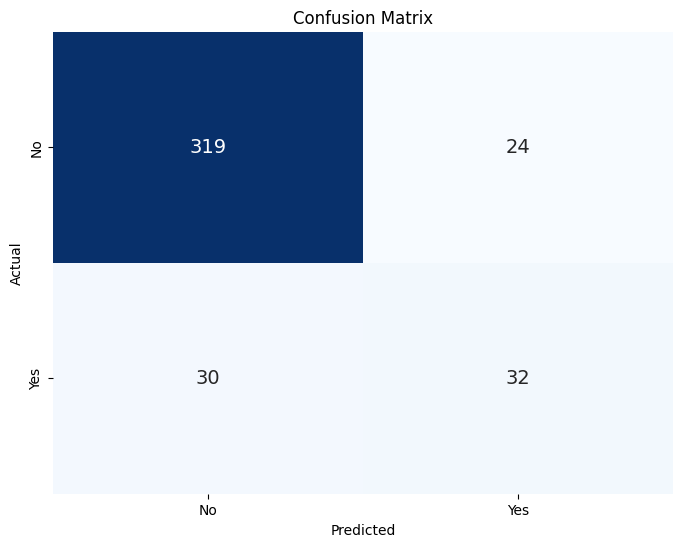

In [70]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'fontsize': 14}, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set the labels for the axes
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.show()

**True Positives is greater than the False Positives**, though not by much, implying that more than half of the customer's who the model predicts to subscribe to the offer, will actually subscribe.

**True Positives is slightly greater than the False Negatives**, implying that the model is accurate in predicting at least half of the customers who will do subscribe to the offer, while the rest will be missed opportunities.

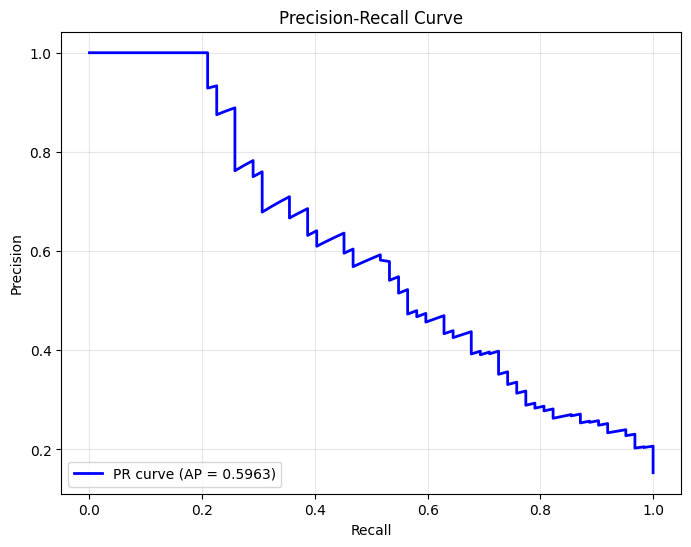

In [72]:
# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label=1)

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_proba, pos_label=1)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

The plot above shows the trade-off between the Precision and Recall, which shows that the Precision of the model is only good at lower Recall.

# 6. Conclusion and Recommendation

### **Final Model Performance and Insights**

The final model achieved the following key performance metrics:

- **Precision-Recall AUC (PR AUC): 0.5963**
- **Precision: 0.5714**
- **Recall: 0.5161**

While these numbers may seem modest, it's important to note that performance expectations ultimately depend on **business objectives** and **risk tolerance** of the stakeholders. In most practical scenarios, aiming for at least **~0.75 across Precision, Recall, and PR AUC** is ideal for high-confidence decision-making—especially when misclassifying potential subscribers has a cost.

---

### **Recommendations for Further Model Improvement**

To improve the model further, consider the following:

- **Use of advanced algorithms for imbalanced classification**, such as deep learning specifically designed for imbalanced binary classification problem.
- **Increase the dataset**, particularly by incorporating more samples of customers who accepted the offer in the past campaign. This will improve the model's ability to generalize, especially on the minority class.

---

### **Strategic Deployment Recommendation**

If the business is willing to **trade off recall (missed opportunities) for higher precision (accuracy of positive predictions)**, we can tune the model to favor **Precision**, as shown in the Precision-Recall (PR) curve:

> At a recall of **0.20–0.30**, the model can achieve **Precision in the range of 0.70–0.90**.

This approach is suitable when the goal is to **minimize false positives**—ensuring that resources (e.g., call center effort) are only used on highly likely responders.

---

### **Actionable Business Insights from Data Analysis**

Beyond the model predictions, leveraging the **EDA insights** can make targeting decisions even more effective. After extracting the list of customers predicted as likely to subscribe, the business can **prioritize based on the following customer profiles**:

- **Marital Status**: Widowed, Single, or Divorced
- **Education**: Completed PhD
- **Income**: Above average
- **Children**: No children (both Kid and Teen)
- **Spending & Purchasing**: Above average in both amount and frequency
- **Recency**: Below average (i.e., recently active customers)

This hybrid strategy—using both **machine learning predictions** and **insight-driven profiling**—offers a more robust and cost-efficient way to target the right customers during the campaign.

---

### **Final Thoughts**

While the current model is **not perfect**, it performs **reasonably well given the data constraints and class imbalance**. More importantly, it provides a **solid foundation** for actionable campaign strategy. Ultimately, the decision to deploy the model should be grounded on whether the current level of performance meets business goals and operational feasibility set by the stakeholders.